In [1]:
import numpy as np
import pandas as pd
import os
import torch
from utils.csv_to_pd import *
from utils.lstm_tool import *

In [2]:

def get_full_9_17(df: pd.DataFrame) -> list[tuple[int, int, np.ndarray]]:
    """
    取得9點~17點
    每10分鐘都有資料的那幾天的發電量

    資料先後順序:
    location, month_day, label_np
    """

    location = df["LocationCode"].unique()
    used_train_data = []
    
    for l in location:
        l_df = df[df["LocationCode"] == l]
        month_day = l_df["month_day"].unique()
        all_day_count = 0
        use_count = 0
        for md in month_day:
            l_md_df = l_df[l_df["month_day"] == md]
            if len(l_md_df) == 48:
                used_train_data.append((int(l), int(md), np.array(l_md_df['Power(mW)'])))
                use_count += 1
            all_day_count += 1
        print(f"loc:{l}, {use_count}/{all_day_count}")
    return used_train_data

def get_data_label(df: pd.DataFrame, target_data: tuple):
    """
    根據target_data的location, month_day, label_np

    取得同個地點、日期所有9:00~17:00以前的數據紀錄

    回傳:
    資料長度、資料、標籤
    """


    location, month_day, label_np = target_data

    support_data = []
    for i in range(9, 17):
        for _ in range(6):
            support_data.append([location / 17, int(month_day / 100) / 12, (i - 9) / 7])

    target_df = df[df["LocationCode"] == location].copy() 
    target_df = target_df[target_df["month_day"] == month_day]
    target_df = target_df.drop(columns=['month_day'])
    if len(target_df) < 6:
        return None
    #去除時間缺失過大的資料
    start = len(target_df) - 1
    end = len(target_df)

    if target_df.iloc[start]['DateTime'].hour == 8:
        while start > 0:
            start -= 1
            if target_df.iloc[start + 1]['DateTime'].hour - target_df.iloc[start + 1]['DateTime'].hour > 1:
                break
    if end - start < 6:
        return None


    target_df = target_df.drop(columns=['DateTime'])
    target_df["LocationCode"] = target_df["LocationCode"] / 17

    data = np.array(target_df)
    label = label_np

    
    return len(data), (data, support_data), label
def get_data_label_list(target_df, target_datas):
    feature_df = get_features(target_df)

    data_label_list = []
    data_label_list_index = 0

    location_month_class = []
    for i in range(18):
        location_month_class.append([])
        for _ in range(13):
            location_month_class[i].append([])



            

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        if data_label != None:
            data_label_list.append(data_label)
            location, month_day, _ = target_data
            location_month_class[location][month_day // 100].append(data_label_list_index)
            data_label_list_index += 1

    return data_label_list, location_month_class

def get_upload_data_list(target_df, target_datas):
    feature_df = get_features(target_df)
    
    data_list = []
    support_data_list = []

    for target_data in target_datas:
        data_label = get_data_label(feature_df, target_data)
        
        if data_label != None:
            _, data_tuple, _ = data_label
            data, support_data = data_tuple
            data_list.append(torch.from_numpy(np.array(data)))
            support_data_list.append(torch.from_numpy(np.array(support_data)))
    return data_list, support_data_list


def get_batch(data: list, support_data: list, label: list, batch_size=64):
    """
    將data跟label根據batch_size切成batch
    """


    batch_datas = []
    batch_labels = []
    batch_support_data = []
    for i in range(0, len(data), batch_size):
        this_batch_length = len(data[i])
        batch_data = []
        for j in range(i, min(i + batch_size, len(data))):
            batch_data.append(data[j][-this_batch_length:len(data[j])])
        
        batch_datas.append(torch.from_numpy(np.array(batch_data)))
        batch_support_data.append(torch.from_numpy(np.array(support_data[i:i + batch_size])))
        batch_labels.append(torch.from_numpy(np.array(label[i:i + batch_size])))
    return batch_datas, batch_support_data, batch_labels

def get_upload_target_list(path="36_TestSet_SubmissionTemplate/upload(no answer).csv"):
    """
    取得上傳答案所需的資料
    格式df, 需要處理的對象
    """

    upload = pd.read_csv(path)
    upload_target_set = set()
    upload_target_list = []
    for u_target in list(upload['序號']):
        month_day = int((u_target % 1e10) / 1e6)
        location = int(u_target % 100)
        if not month_day * 100 + location in upload_target_set:
            upload_target_set.add(month_day * 100 + location)
            upload_target_list.append((location, month_day, np.array(list(range(48)))))
    return upload, upload_target_list


def get_features(target_df: pd.DataFrame, before_time=9, start_time=4):
    feature_df_before = target_df[target_df['DateTime'].dt.hour < before_time]
    feature_df_before = feature_df_before[feature_df_before['DateTime'].dt.hour > start_time]

    return feature_df_before



In [3]:
from sklearn.preprocessing import StandardScaler

#取得做完各種處理的dataframe
target_df = read_dir_csv()
target_df = mean_min(target_df, 10)
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])
target_df["month_day"] = target_df['DateTime'].dt.month * 100 + target_df['DateTime'].dt.day
target_df['month'] = target_df['DateTime'].dt.month
target_df['hour'] = target_df['DateTime'].dt.hour

copy_target_df = target_df.copy()

#取得所有可用的訓練資料 target_datas
after_9 = target_df[target_df['DateTime'].dt.hour >= 9].drop(columns=["WindSpeed(m/s)", "Pressure(hpa)", "Temperature(°C)", "Humidity(%)", "Sunlight(Lux)"])
between_9_17 = after_9[after_9['DateTime'].dt.hour < 17]
mean_10_between_9_17 = mean_min(between_9_17)
target_datas = get_full_9_17(mean_10_between_9_17)

# 標準化
columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', "month", "Power(mW)", 'hour']
scaler = StandardScaler()
target_df[columns_to_standardize] = scaler.fit_transform(target_df[columns_to_standardize])



c:\Users\weiso131\Desktop\power_generation_predict\utils\csv_to_pd.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])


loc:10.0, 120/126
loc:11.0, 69/78
loc:12.0, 114/126
loc:13.0, 80/97
loc:14.0, 74/90
loc:15.0, 98/116
loc:16.0, 97/106
loc:17.0, 117/124
loc:1.0, 107/145
loc:2.0, 99/124
loc:3.0, 61/85
loc:4.0, 80/88
loc:5.0, 61/70
loc:6.0, 60/62
loc:7.0, 59/72
loc:8.0, 148/199
loc:9.0, 108/136


In [4]:
# 根據target_datas生成train和valid
data_label_list, location_month_class = get_data_label_list(target_df, target_datas)






In [5]:
import random

def random_split_with_class(data_label_list, location_month_class, train_ratio=0.9):
    min_data_num = int(1 / (1 - train_ratio) / 2)

    train_indices = []
    valid_indices = []

    for i in range(1, 18):
        for j in range(1, 13):
            if len(location_month_class[i][j]) < min_data_num:
                train_indices.extend(location_month_class[i][j])
            else:
                for k in location_month_class[i][j]:
                    r = random.random()
                    if r < train_ratio:
                        train_indices.append(k)
                    else:
                        valid_indices.append(k)
    train_data_label_list = [data_label_list[i] for i in train_indices]
    valid_data_label_list = [data_label_list[i] for i in valid_indices]

    return train_data_label_list, valid_data_label_list


In [6]:

train_data_label_list, valid_data_label_list = random_split_with_class(data_label_list, location_month_class, 0.92)
train_data_tuple, train_label, train_length = sort_by_length(train_data_label_list)
train_data, train_support_data = list(zip(*train_data_tuple))
valid_data_tuple, valid_label, valid_length = sort_by_length(valid_data_label_list)
valid_data, valid_support_data = list(zip(*valid_data_tuple))
print(len(train_data_label_list), len(valid_data_label_list))

1421 124


In [7]:
# import torch
# import torch.nn as nn

# class LSTMTagger(nn.Module):

#     def __init__(self, hidden_dim, tagset_size=1, input_dim=8, support_dim=3, cnn_out_channels=32):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim

#         # CNN 模塊
#         self.conv1 = nn.Conv1d(input_dim, cnn_out_channels, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv1d(cnn_out_channels, cnn_out_channels, kernel_size=3, stride=2, padding=1)

#         # CNN LSTM (CNN + LSTM)
#         self.cnn_lstm = nn.LSTM(cnn_out_channels, hidden_dim, batch_first=True, dropout=0.3)

#         # Output LSTM (兩層)
#         self.output_lstm = nn.LSTM(support_dim, hidden_dim, batch_first=True, num_layers=1, dropout=0.3)

#         # 線性層
#         self.linear = nn.Linear(hidden_dim, tagset_size)
#         self.relu = nn.ReLU()

#         self.cnn_dropout = nn.Dropout(0.4)

#     def init_hidden(self, batch_size, num_layers=1):
#         # 初始化隱藏狀態和細胞狀態
#         return (torch.zeros(num_layers, batch_size, self.hidden_dim),
#                 torch.zeros(num_layers, batch_size, self.hidden_dim))

#     def forward(self, data, support, hidden):
#         """
#         data: Tensor, shape (batch_size, seq_len, input_dim)
#         support: Tensor, shape (batch_size, seq_len, support_dim)
#         hidden: Initial hidden state

#         Returns:
#             tag_space: Tensor, shape (batch_size, tagset_size)
#             hidden: Final hidden state
#         """
#         # CNN + LSTM
#         x = data.permute(0, 2, 1)  # (batch_size, input_dim, seq_len)
#         x = torch.relu(self.conv1(x))
#         x = self.cnn_dropout(x)
#         x = torch.relu(self.conv2(x))  # (batch_size, cnn_out_channels, reduced_seq_len)
#         x = self.cnn_dropout(x)
#         x = x.permute(0, 2, 1)  # (batch_size, reduced_seq_len, cnn_out_channels)
#         _, hidden_cnn = self.cnn_lstm(x, hidden)  # 提取局部特徵後的全局模式

#         # 使用 CNN LSTM 的隱藏狀態
#         combined_hidden = hidden_cnn  # 直接使用 CNN LSTM 的隱藏狀態

#         # Support 特徵輸入 Output LSTM
#         output, (hidden_out, cell_out) = self.output_lstm(support, combined_hidden)

#         # 線性層和激活函數
#         tag_space = self.relu(self.linear(self.relu(output)))

#         return tag_space, (hidden_out, cell_out)

In [8]:
import torch
import torch.nn as nn

class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size=1, input_dim=8, support_dim=3, cnn_out_channels=16):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # Feature LSTM (直接處理輸入資料)
        self.feature_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # CNN 模塊
        self.conv1 = nn.Conv1d(input_dim, cnn_out_channels, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(cnn_out_channels, cnn_out_channels, kernel_size=3, stride=2, padding=1)

        # CNN LSTM (CNN + LSTM)
        self.cnn_lstm = nn.LSTM(cnn_out_channels, hidden_dim, batch_first=True, dropout=0.3)

        # Output LSTM (兩層)
        self.output_lstm = nn.LSTM(support_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.3)

        # 線性層
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()
        self.cnn_dropout = nn.Dropout(0.4)

    def init_hidden(self, batch_size, num_layers=1):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(num_layers, batch_size, self.hidden_dim),
                torch.zeros(num_layers, batch_size, self.hidden_dim))

    def forward(self, data, support, hidden):
        """
        data: Tensor, shape (batch_size, seq_len, input_dim)
        support: Tensor, shape (batch_size, seq_len, support_dim)
        hidden: Initial hidden state

        Returns:
            tag_space: Tensor, shape (batch_size, tagset_size)
            hidden: Final hidden state
        """
        # Feature LSTM
        _, hidden_feature = self.feature_lstm(data, hidden)  # 提取全局特徵 (batch_size, seq_len, hidden_dim)

        # CNN + LSTM
        x = data.permute(0, 2, 1)  # (batch_size, input_dim, seq_len)
        x = torch.relu(self.conv1(x))
        x = self.cnn_dropout(x)
        x = torch.relu(self.conv2(x))  # (batch_size, cnn_out_channels, reduced_seq_len)
        x = self.cnn_dropout(x)
        x = x.permute(0, 2, 1)  # (batch_size, reduced_seq_len, cnn_out_channels)
        _, hidden_cnn = self.cnn_lstm(x, hidden)  # 提取局部特徵後的全局模式

        # 合併兩個 LSTM 的隱藏狀態
        combined_hidden = torch.cat([hidden_feature[0], hidden_cnn[0]], dim=0)  # (1, batch_size, 2 * hidden_dim)
        combined_cell = torch.cat([hidden_feature[1], hidden_cnn[1]], dim=0)
        


        # 擴展 Support 並進行 Output LSTM
        output, (hidden_out, cell_out) = self.output_lstm(support, (combined_hidden, combined_cell))

        # 線性層和激活函數
        tag_space = self.relu(self.linear(self.relu(output)))

        return tag_space, (hidden_out, cell_out)

In [9]:
import torch.optim as optim

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def custom_loss(predictions, targets, lambda_rate=0.5):
    mse_loss = torch.mean((predictions - targets) ** 2)
    diff_loss = torch.mean((predictions[:, 1:] - predictions[:, :-1]) - (targets[:, 1:] - targets[:, :-1]) ** 2)
    return mse_loss + lambda_rate * diff_loss

# 定義訓練函數
def train_model(model, train_loader, valid_loader, train_length, valid_length, num_epochs=10, learning_rate=0.001):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.SmoothL1Loss()
    min_loss = 1e9

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, support_datas, labels in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, support_datas, labels = inputs.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, support_datas, hidden)

            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            train_loss += loss.item()

        

        # 驗證模型
        valid_loss, valid_error  = validate_model(model, valid_loader, criterion, valid_length)
        if valid_loss < min_loss:
            min_loss = valid_loss
            torch.save(model.state_dict(), "checkpoint.pth" )
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / train_length:.4f}")
            print(f"valid_loss:{valid_loss}, valid_error:{valid_error}")


# 定義驗證函數
def validate_model(model, valid_loader, criterion, valid_length):
    model.eval()
    total_loss = 0.0
    error = 0
    MAE_loss = nn.L1Loss()
    with torch.no_grad():
        for inputs, support_datas, labels in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, support_datas, labels = inputs.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, support_datas, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels.squeeze())
            error += MAE_loss(outputs.squeeze(), labels.squeeze())
            total_loss += loss.item()

    return total_loss / valid_length, error / valid_length


In [10]:
batch = 64
batch_train_data, batch_train_support_data, batch_train_label = get_batch(train_data, train_support_data, train_label, batch)
batch_valid_data, batch_valid_support_data, batch_valid_label = get_batch(valid_data, valid_support_data, valid_label, batch)
train_loader = list(zip(batch_train_data, batch_train_support_data, batch_train_label))
valid_loader = list(zip(batch_valid_data, batch_valid_support_data, batch_valid_label))

print(batch_train_data[0].shape, batch_train_support_data[0].shape, batch_train_label[0].shape)

torch.Size([64, 7, 9]) torch.Size([64, 48, 3]) torch.Size([64, 48])


In [11]:
model = LSTMTagger(128, 1, input_dim=train_data[0].shape[1])
train_length, valid_length = len(batch_train_data), len(batch_valid_data)
train_model(model, train_loader, valid_loader, train_length, valid_length, 2000, learning_rate=0.005)


c:\Users\weiso131\anaconda3\envs\AI\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/2000], Training Loss: 374.8954
valid_loss:389.4810791015625, valid_error:389.976806640625
Epoch [2/2000], Training Loss: 370.7064
valid_loss:386.88560485839844, valid_error:387.3832702636719
Epoch [3/2000], Training Loss: 368.4892
valid_loss:385.2640075683594, valid_error:385.7620849609375
Epoch [4/2000], Training Loss: 366.9699
valid_loss:383.95135498046875, valid_error:384.4490966796875
Epoch [5/2000], Training Loss: 365.9733
valid_loss:383.16224670410156, valid_error:383.660400390625
Epoch [6/2000], Training Loss: 365.3101
valid_loss:382.61378479003906, valid_error:383.11260986328125
Epoch [7/2000], Training Loss: 364.8347
valid_loss:382.2183837890625, valid_error:382.71728515625
Epoch [8/2000], Training Loss: 364.4891
valid_loss:381.92694091796875, valid_error:382.42596435546875
Epoch [9/2000], Training Loss: 364.2306
valid_loss:381.7058410644531, valid_error:382.2044677734375
Epoch [10/2000], Training Loss: 364.0246
valid_loss:381.5237731933594, valid_error:382.0226745605

KeyboardInterrupt: 

In [12]:
check_point = torch.load("checkpoint.pth")
model = LSTMTagger(128, 1, input_dim=train_data[0].shape[1])
model.load_state_dict(check_point)
model = model.to('cuda', dtype=torch.float32)


In [13]:
validate_model(model, valid_loader, nn.SmoothL1Loss(), valid_length)

(164.30329513549805, tensor(164.7910, device='cuda:0'))

(64, 48) (64, 48)
torch.Size([64, 48, 3])


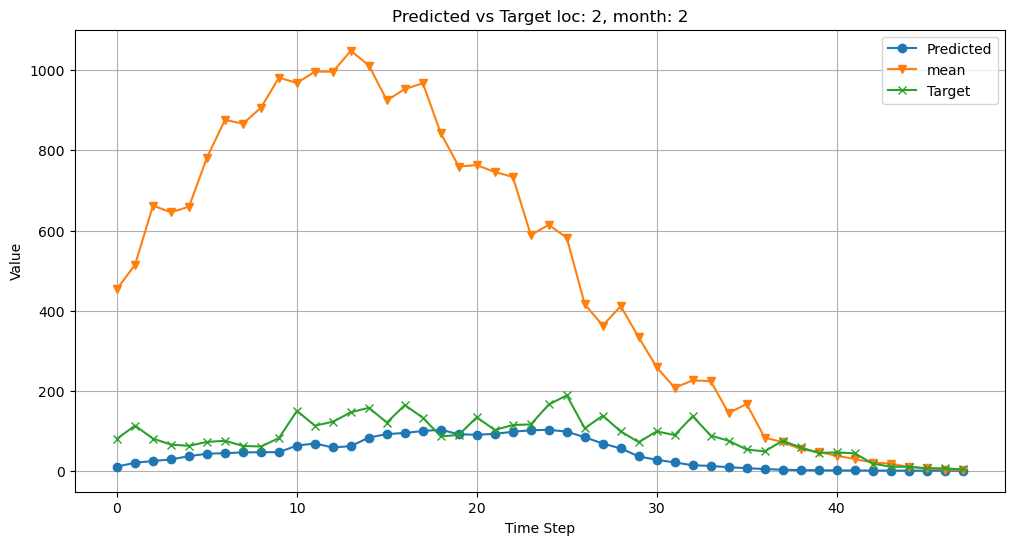

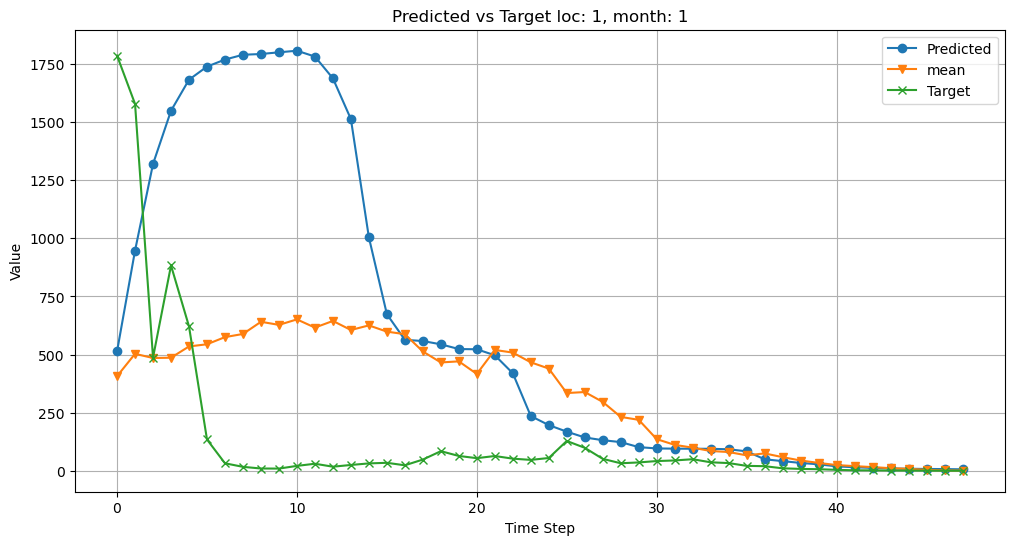

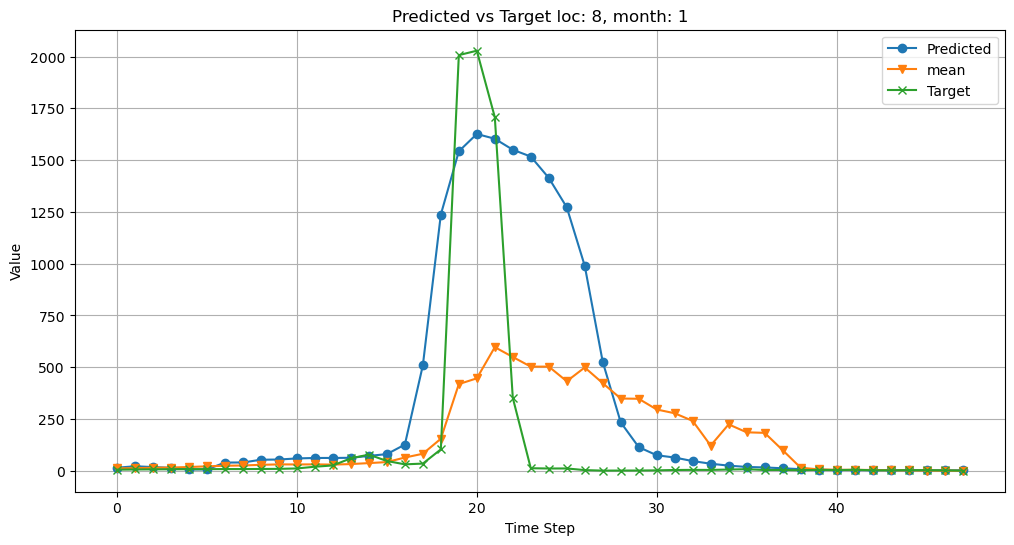

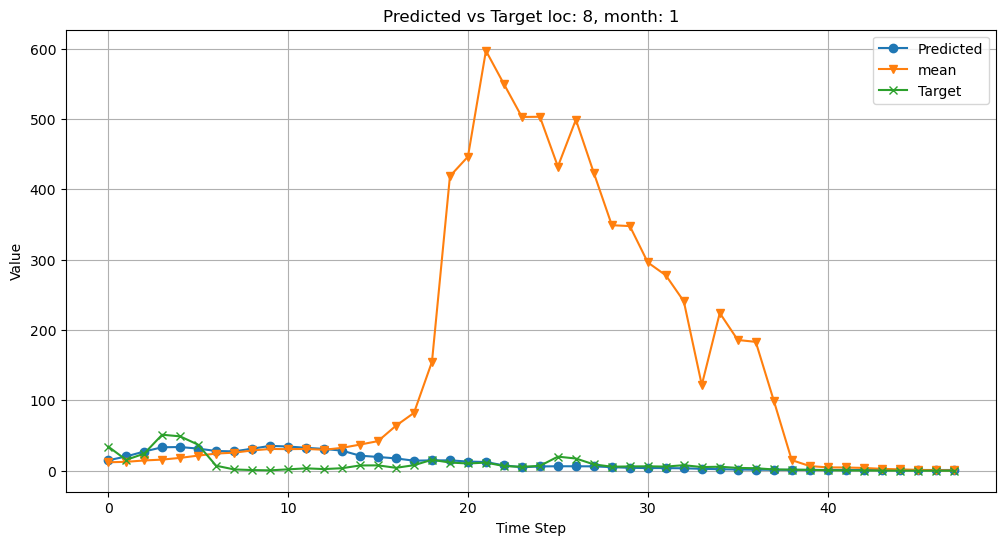

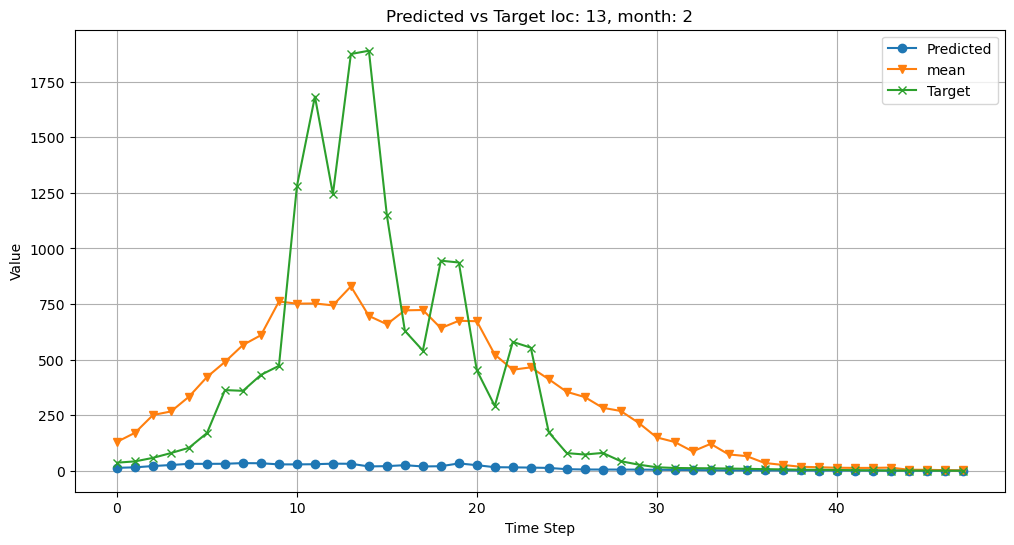

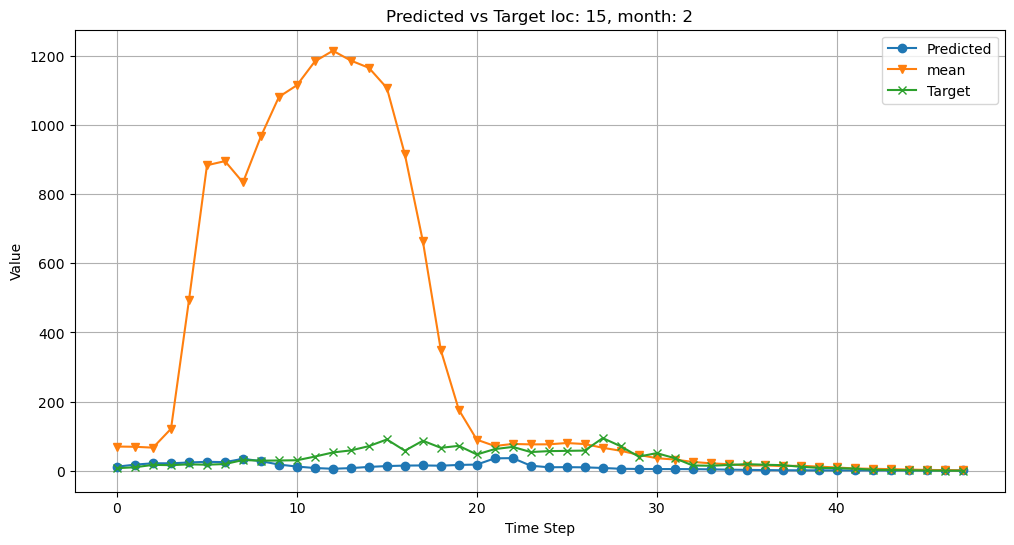

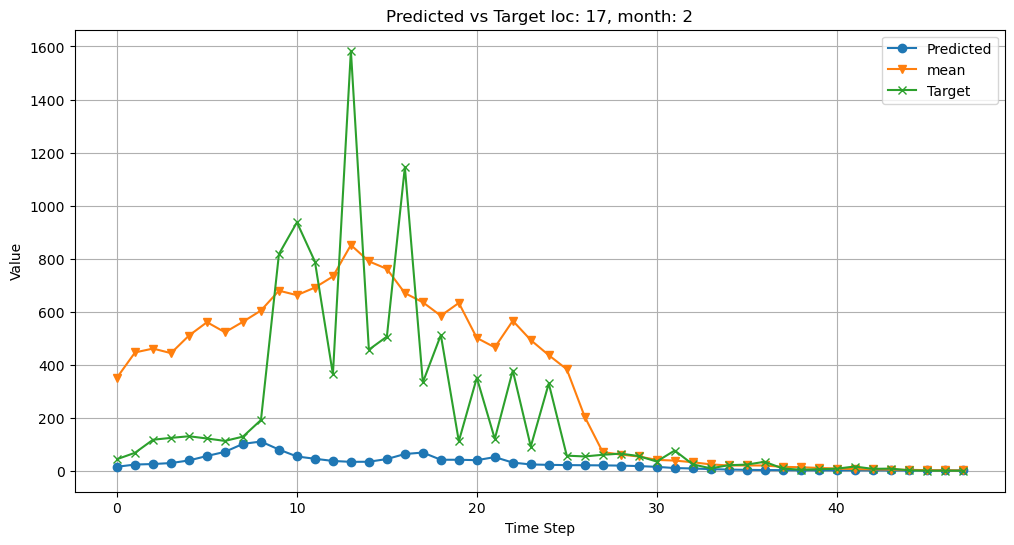

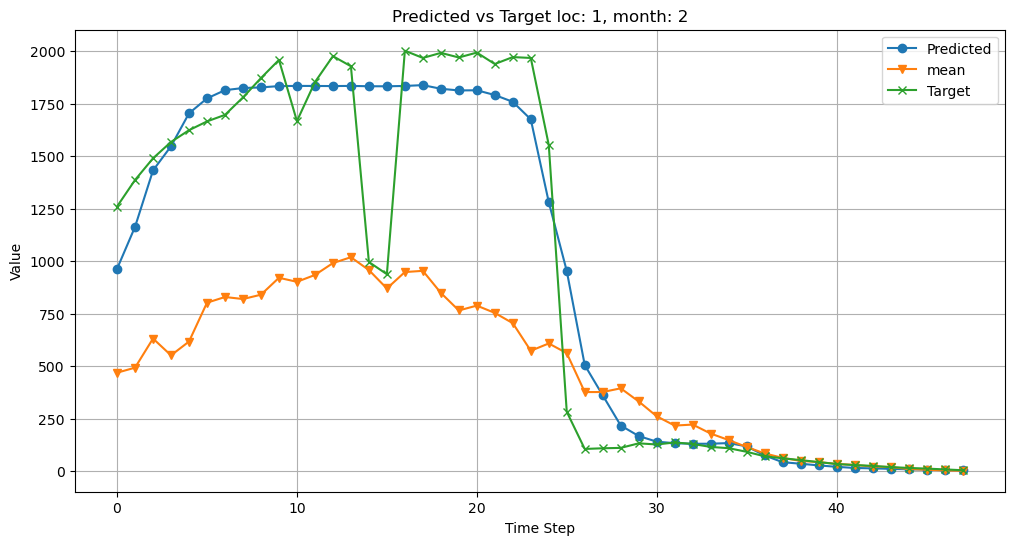

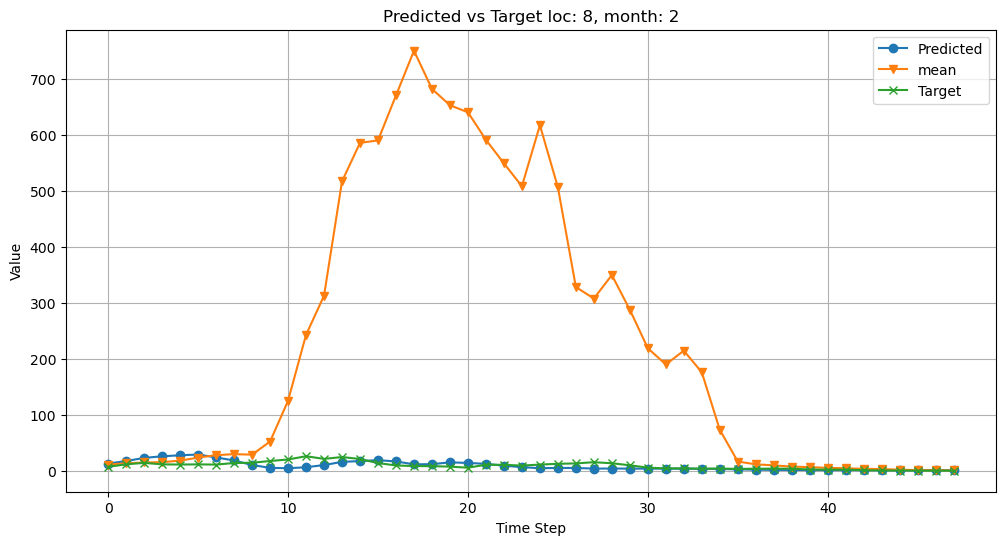

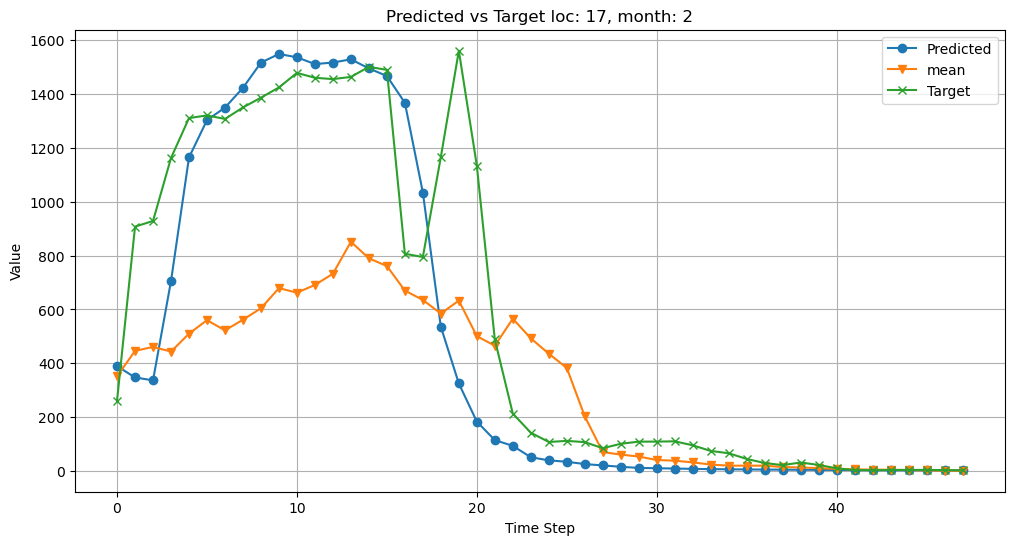

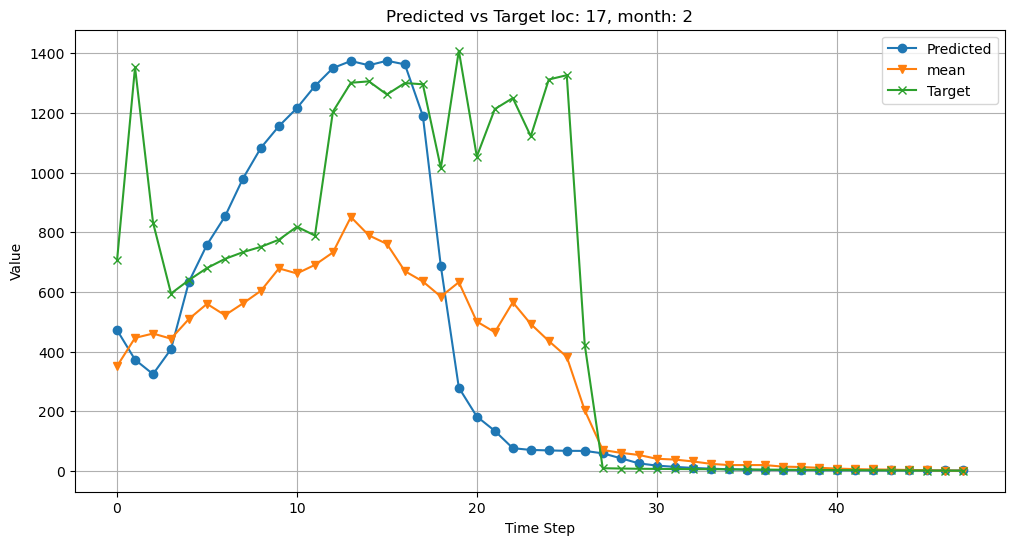

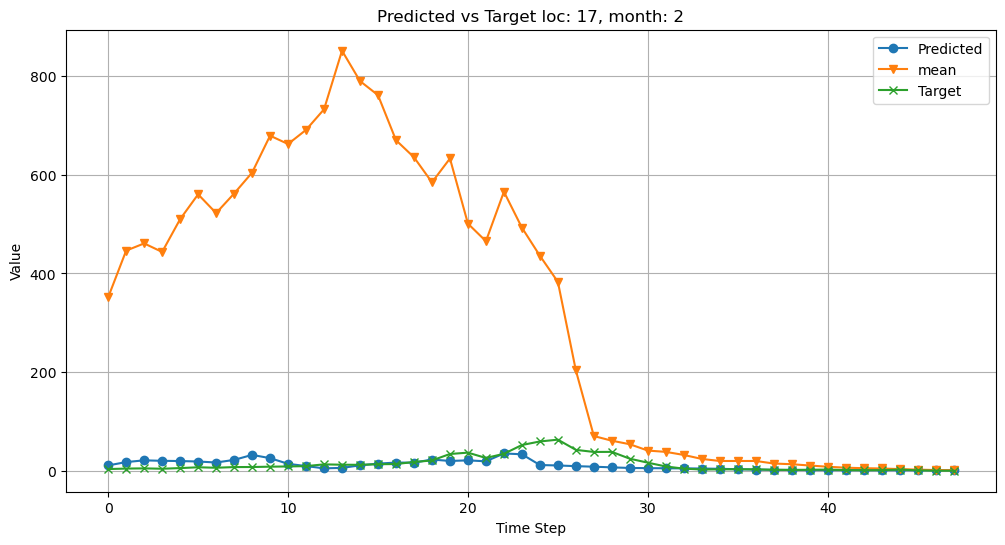

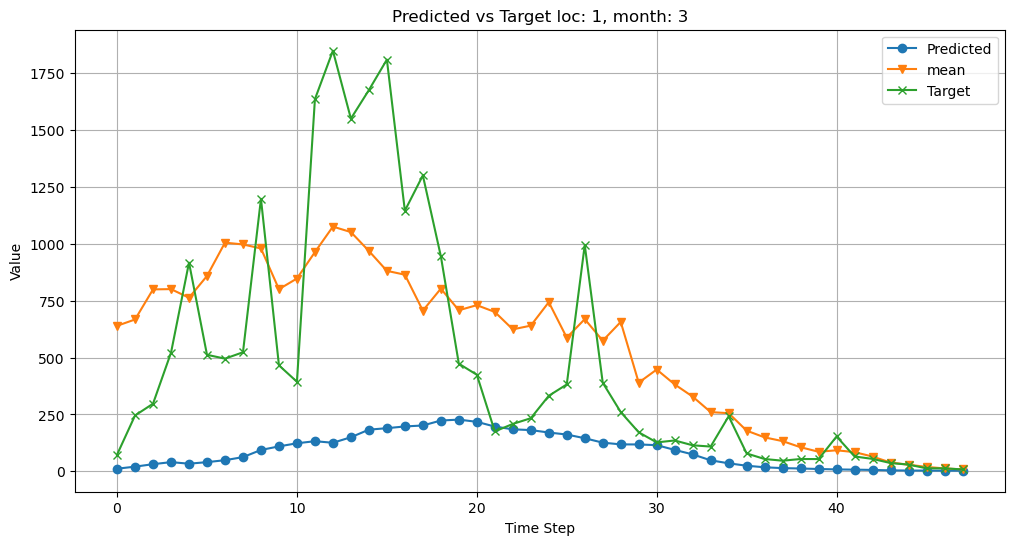

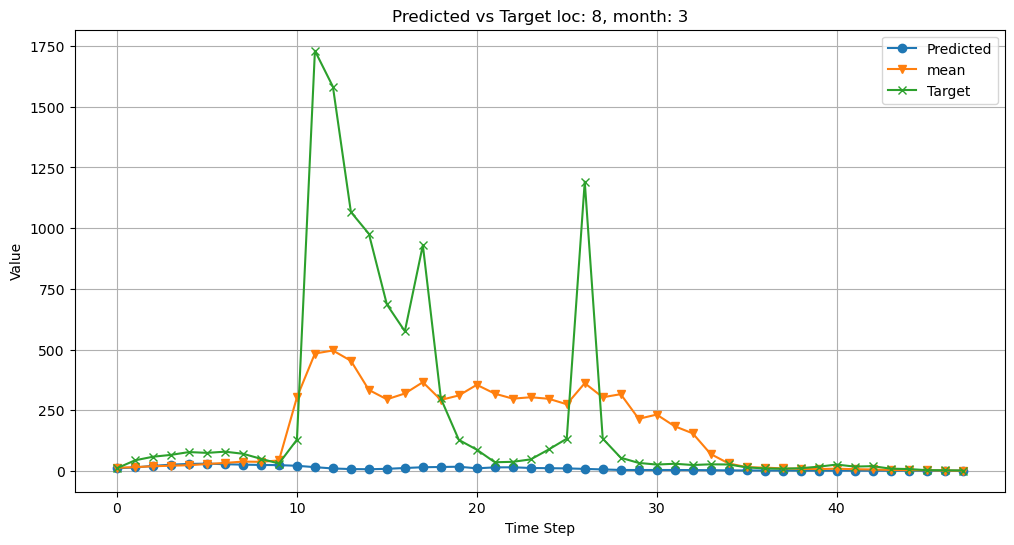

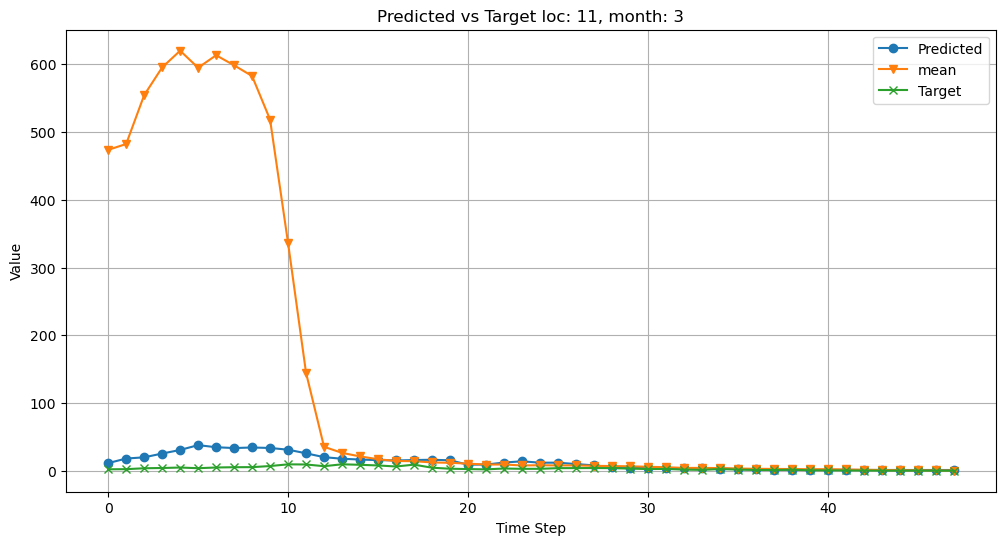

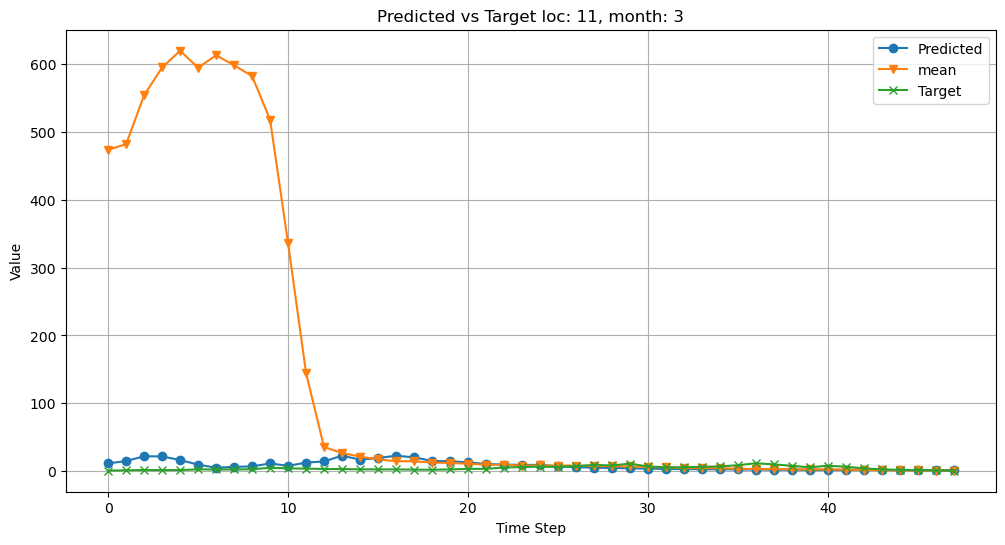

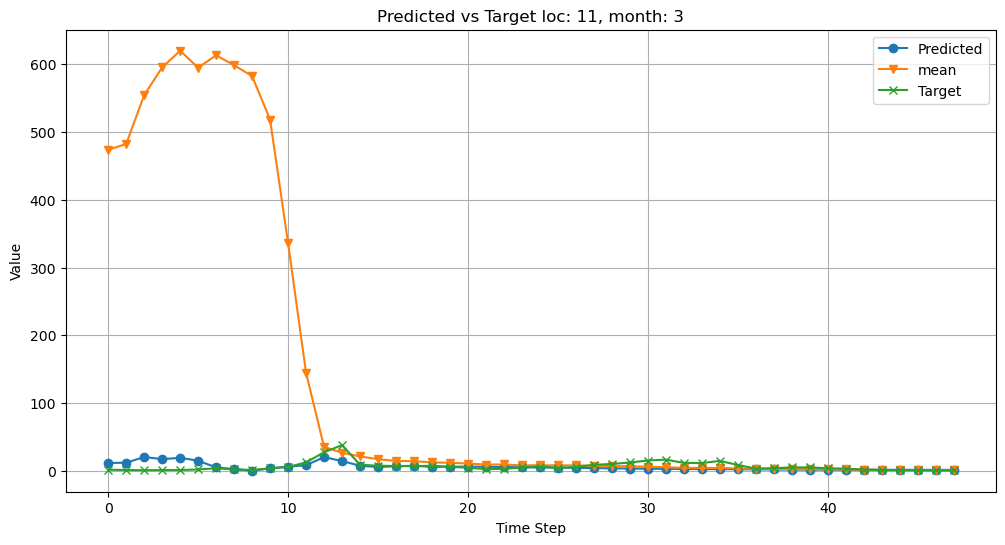

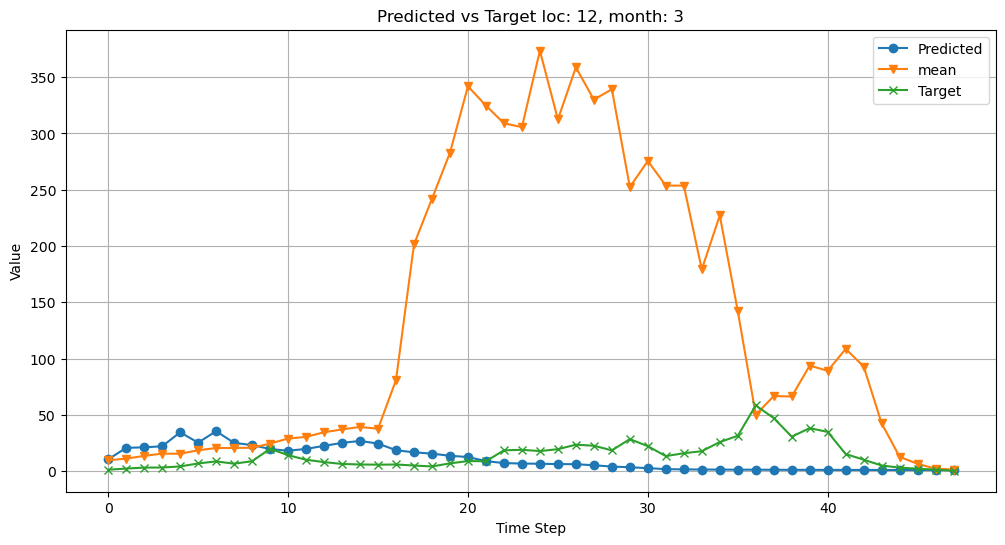

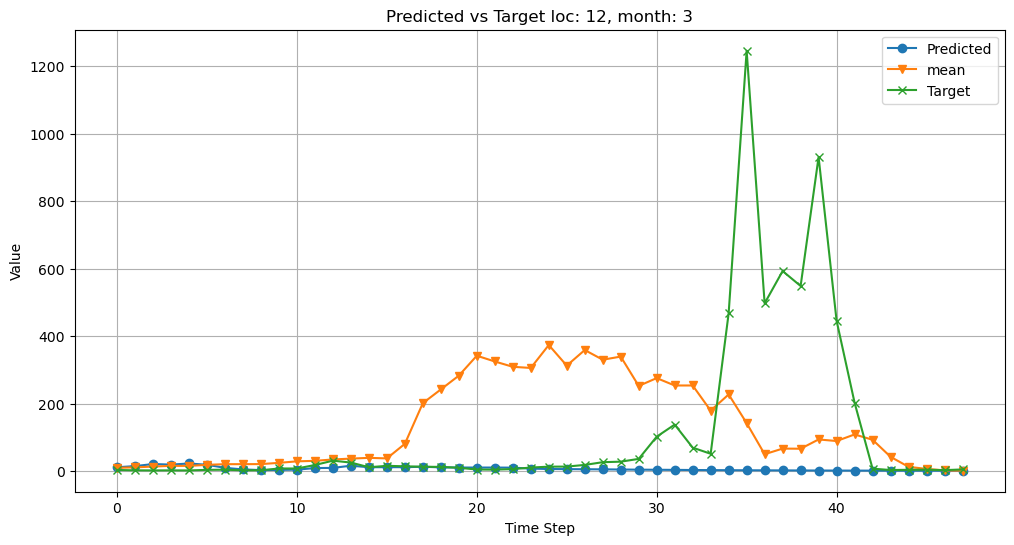

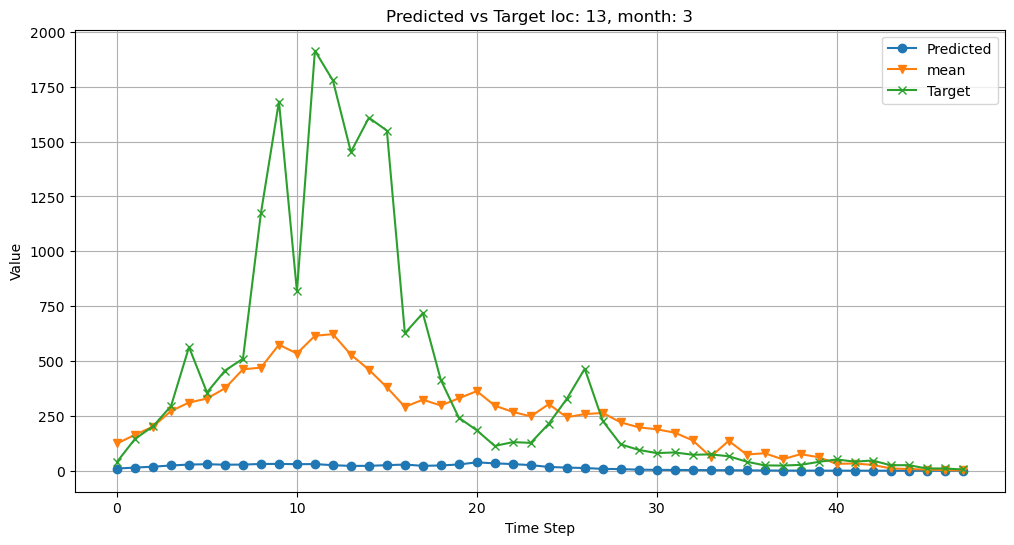

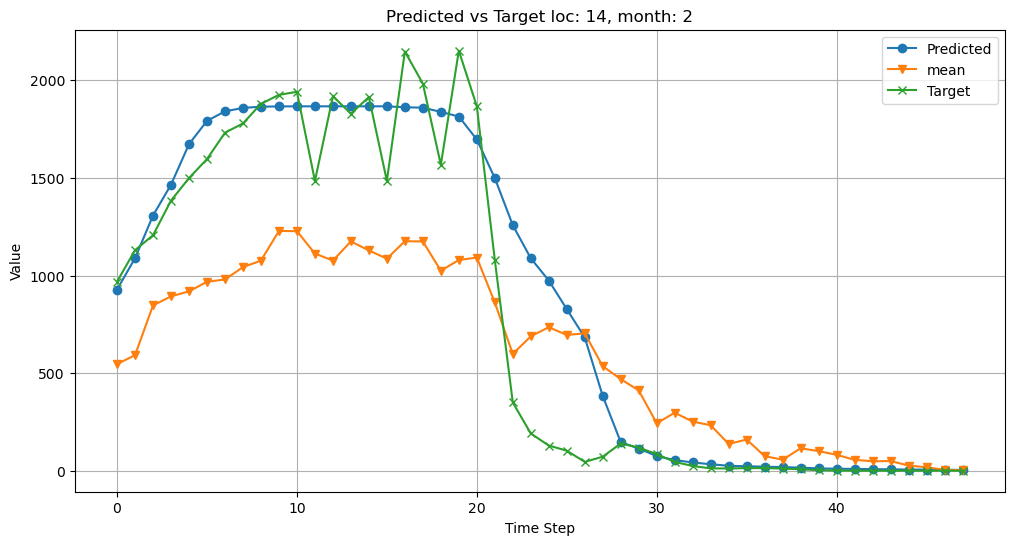

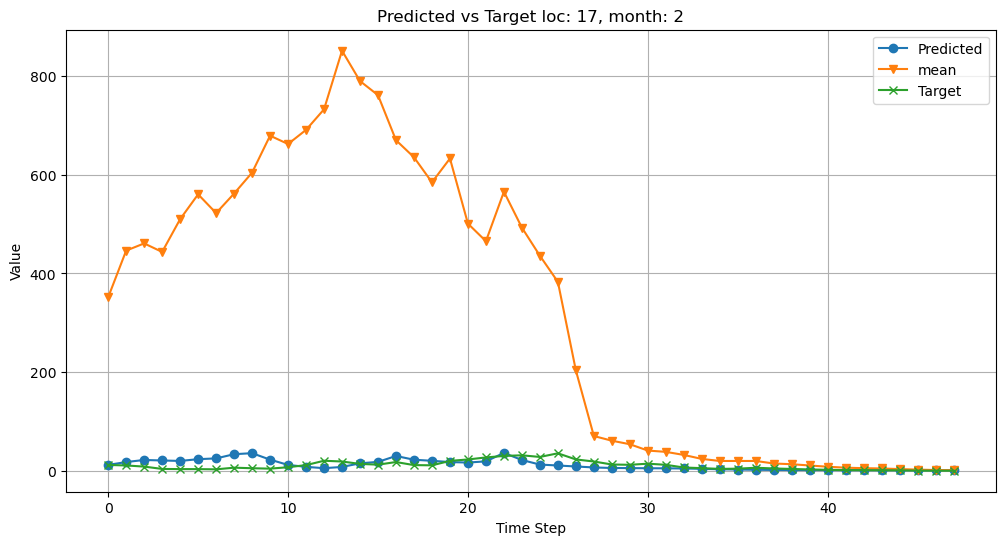

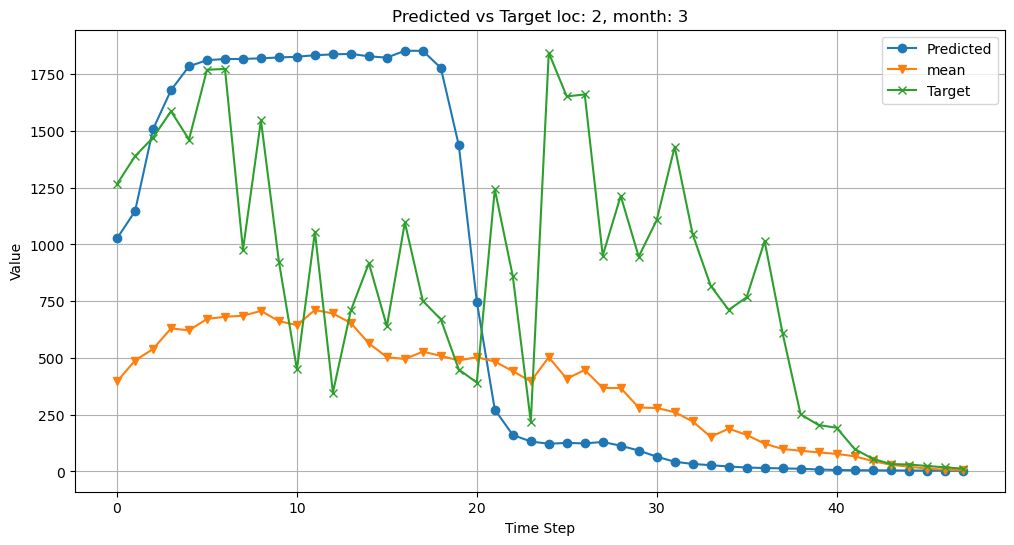

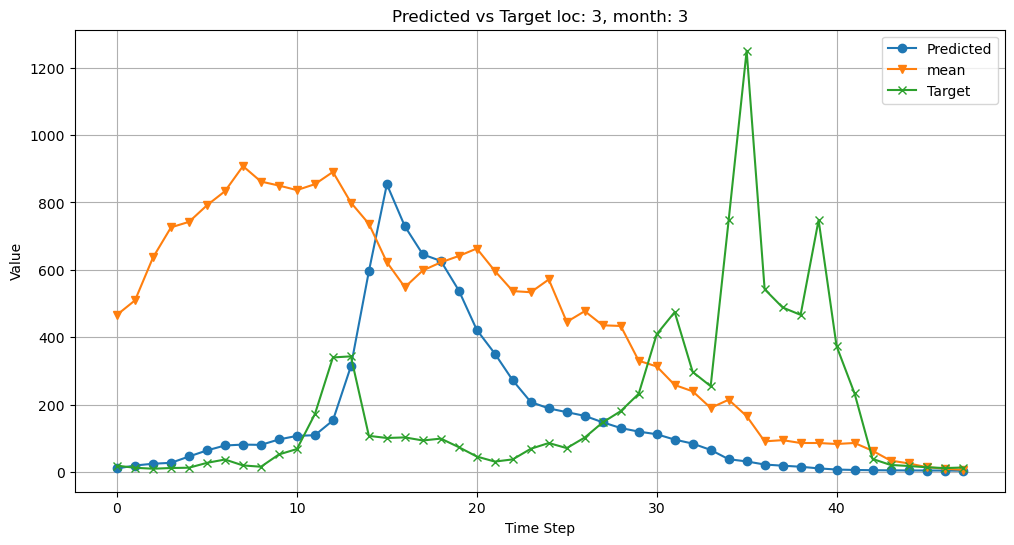

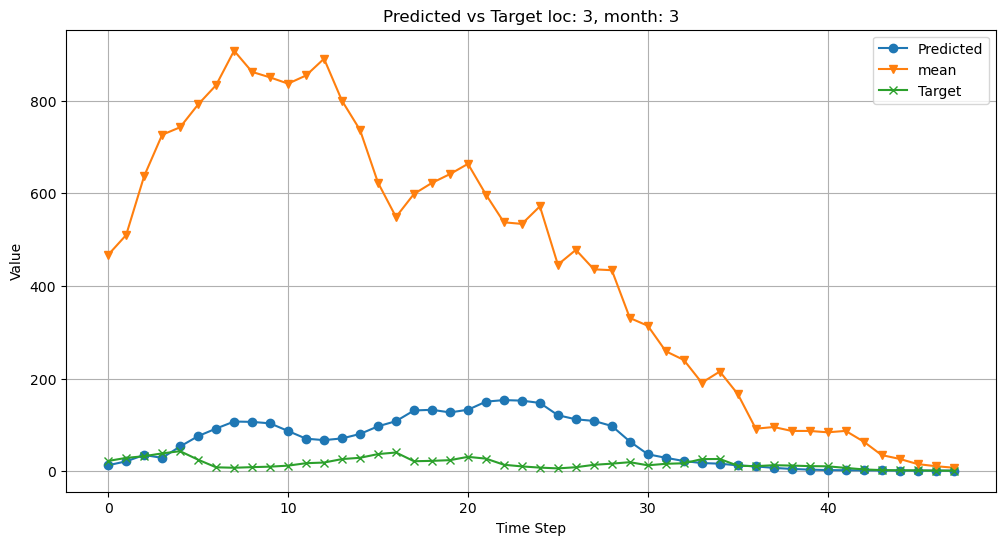

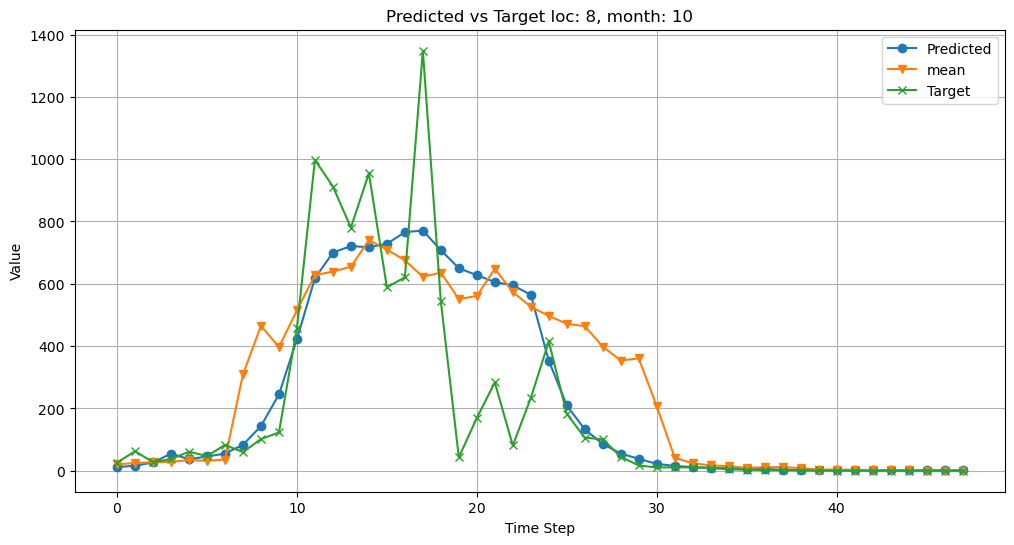

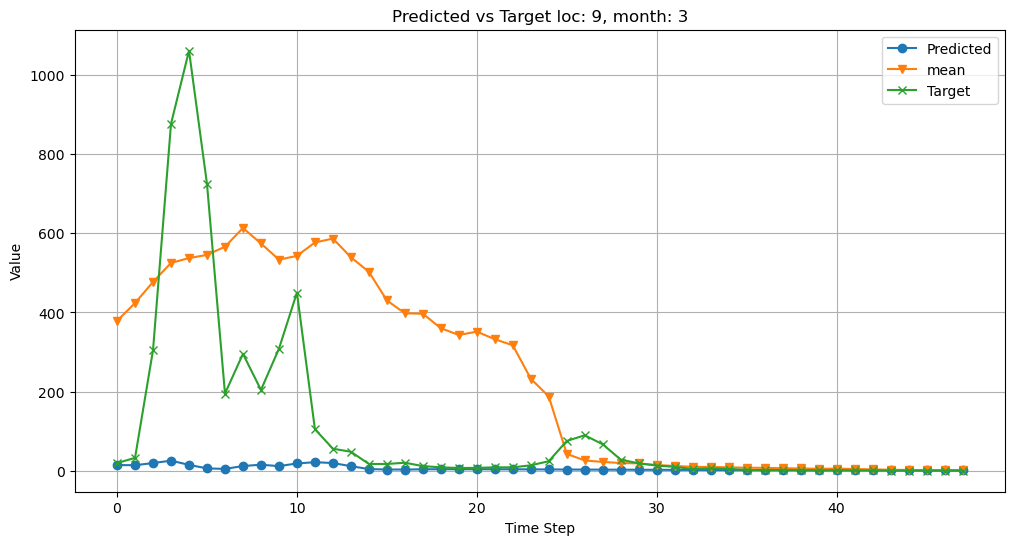

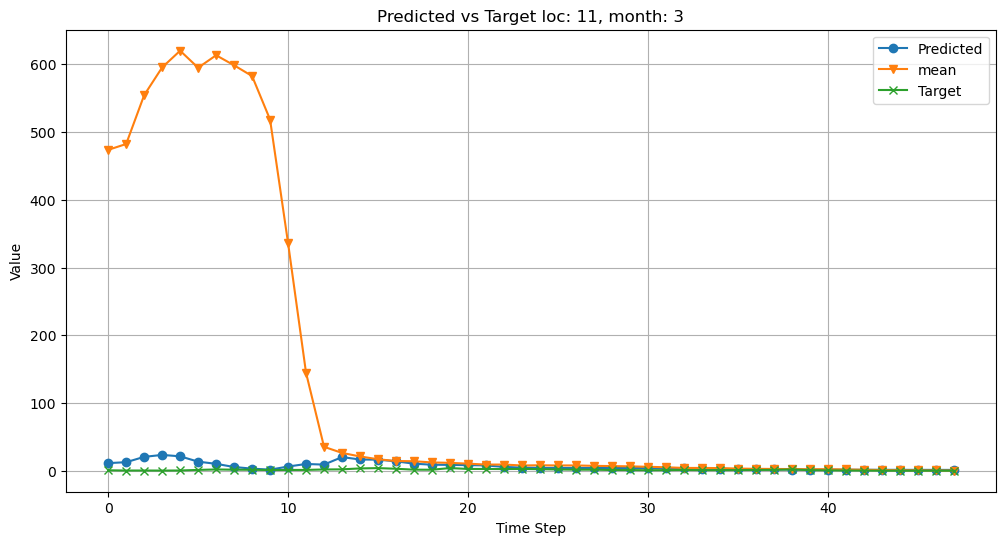

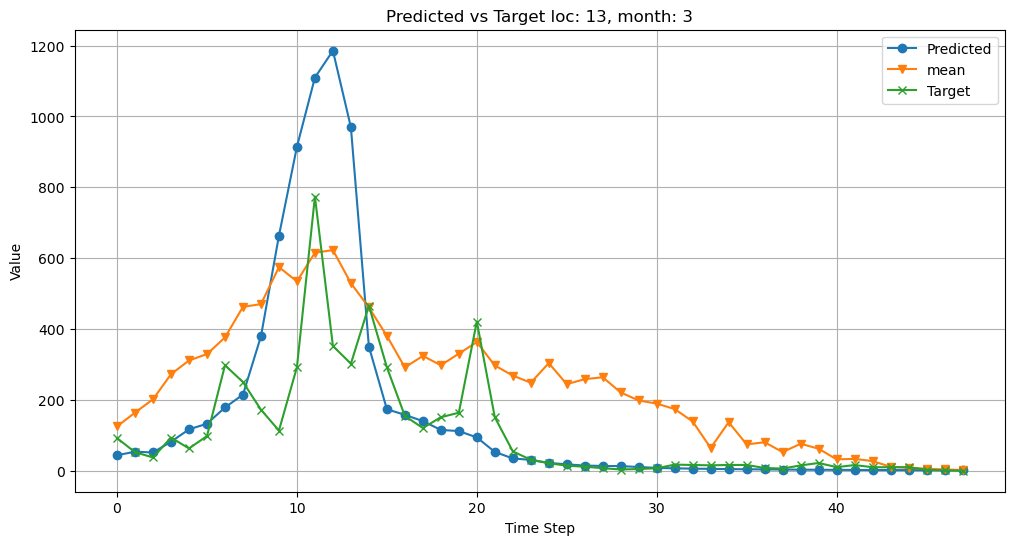

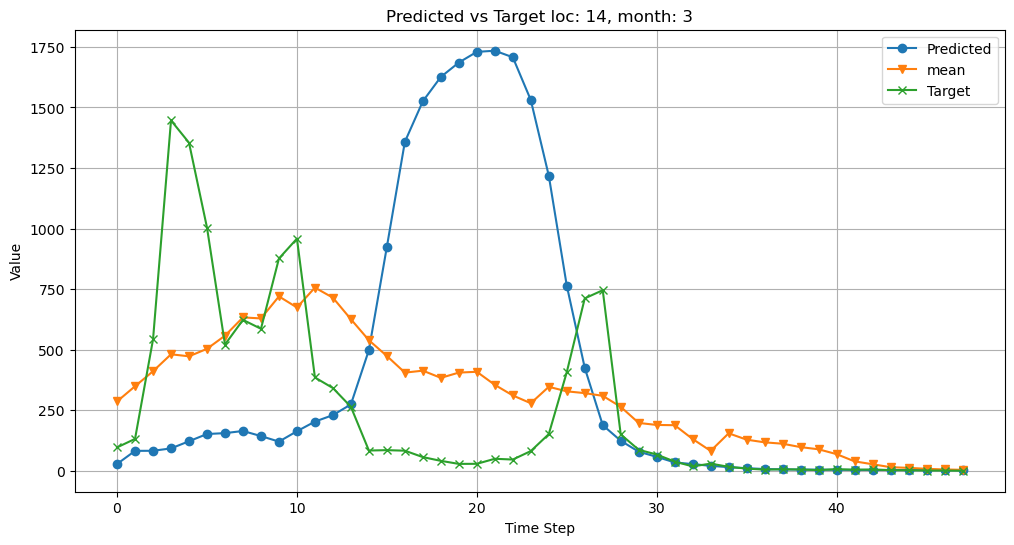

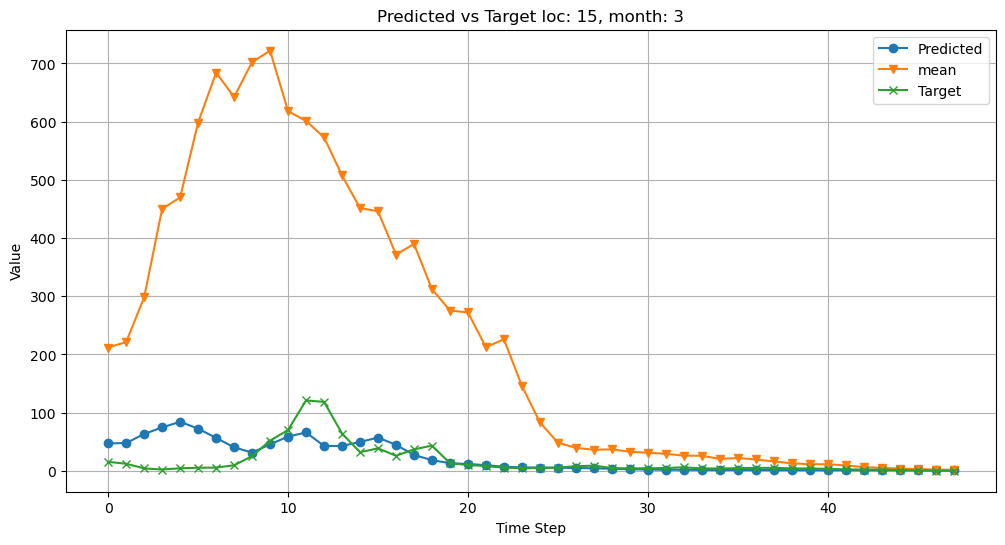

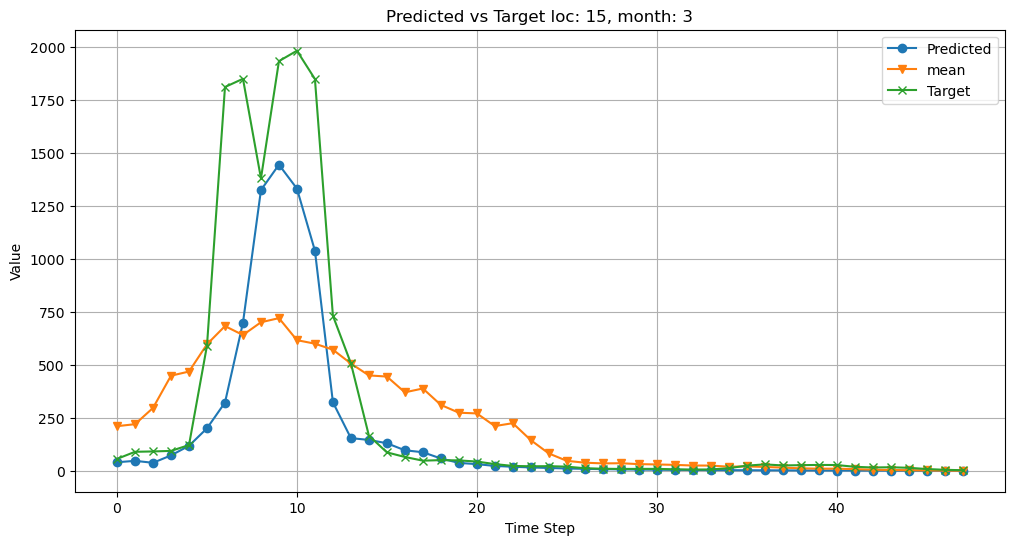

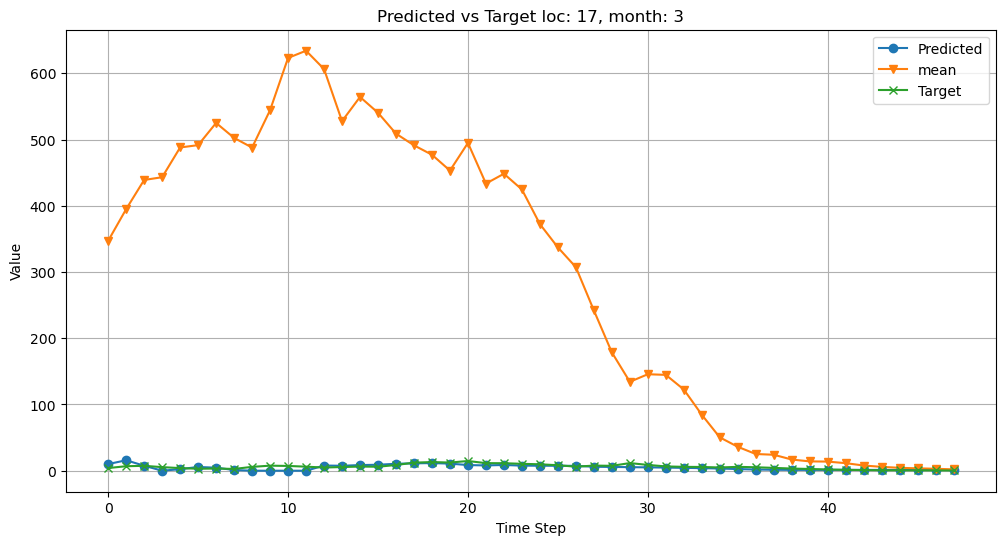

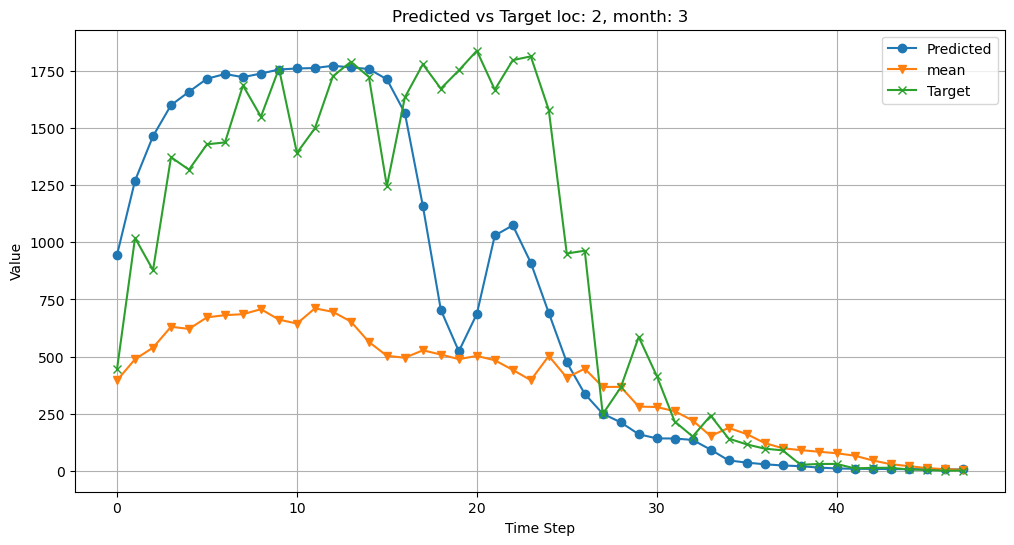

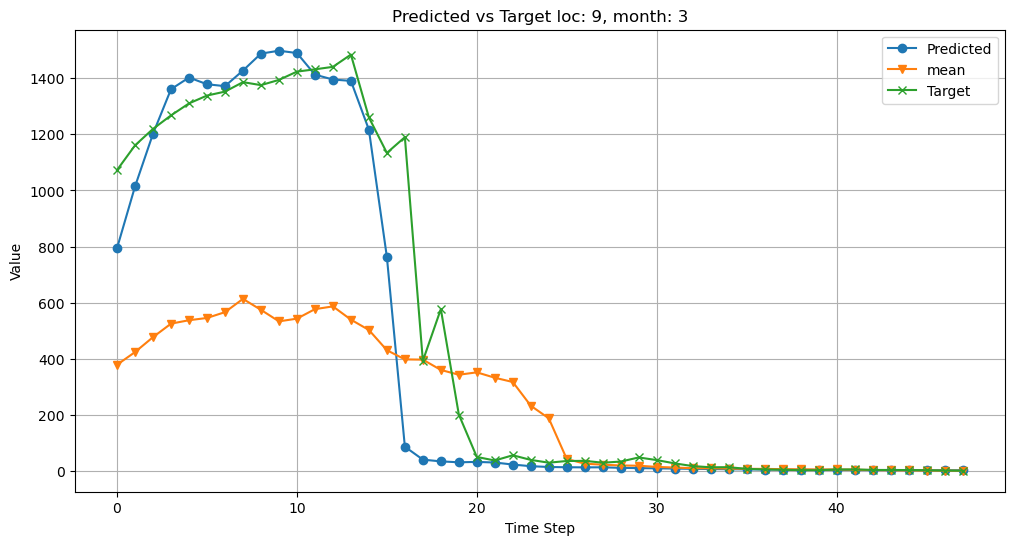

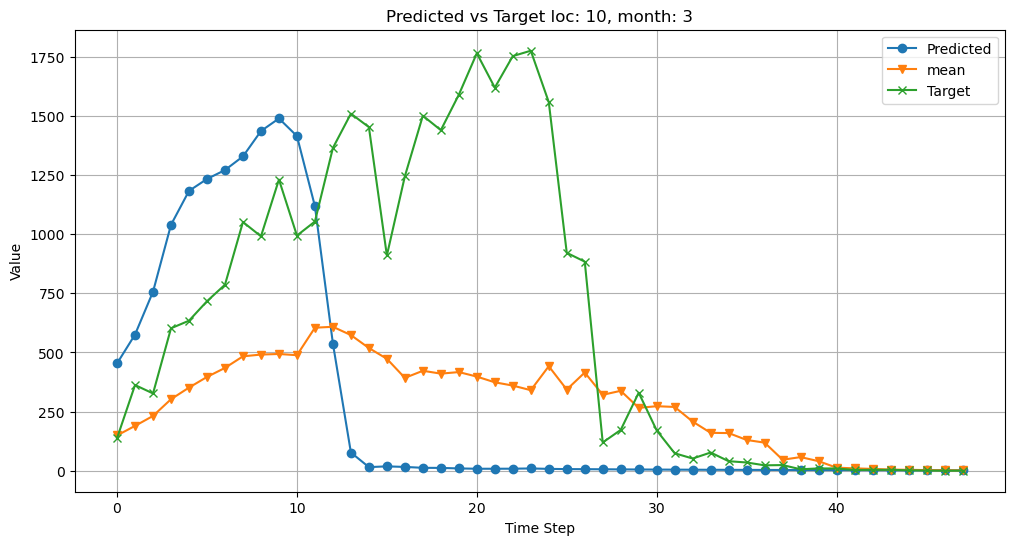

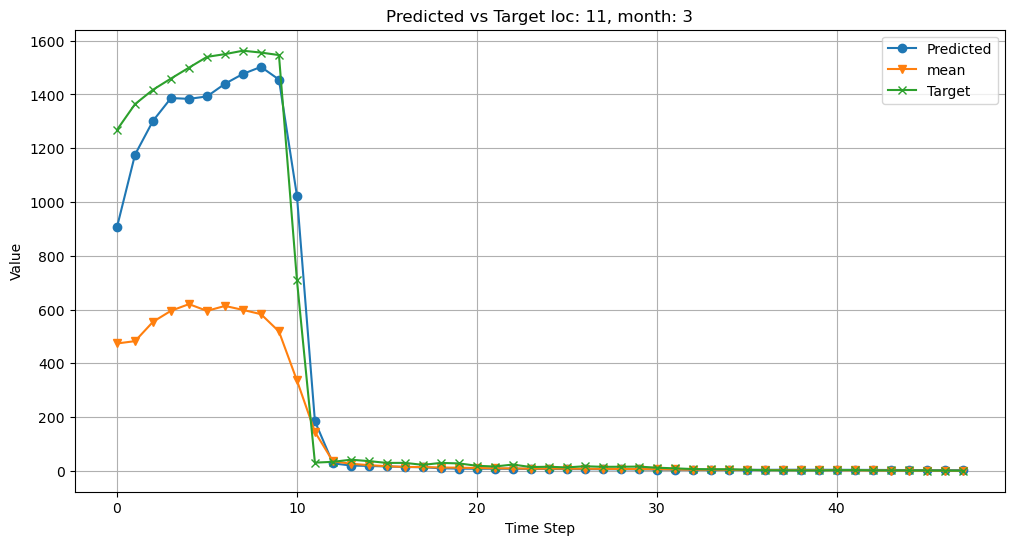

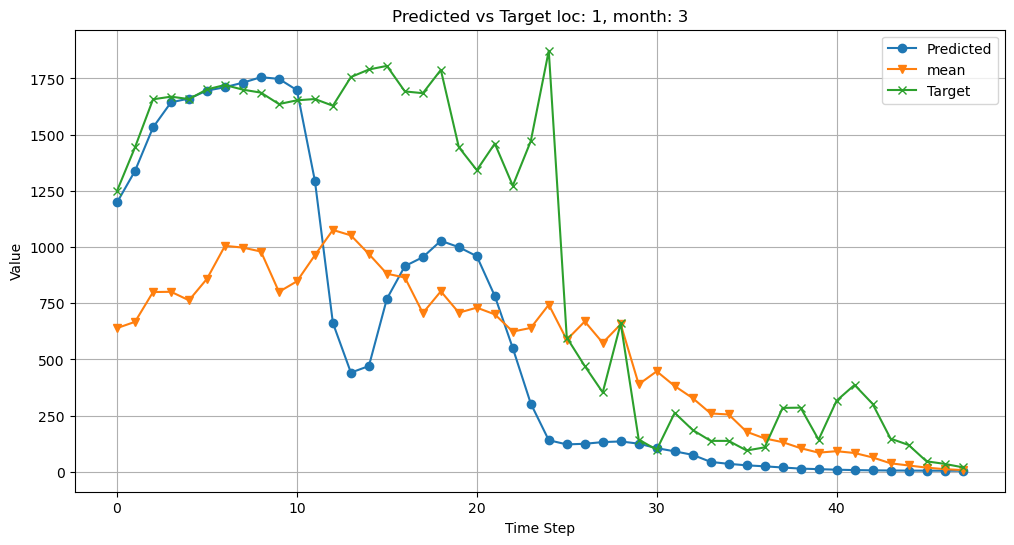

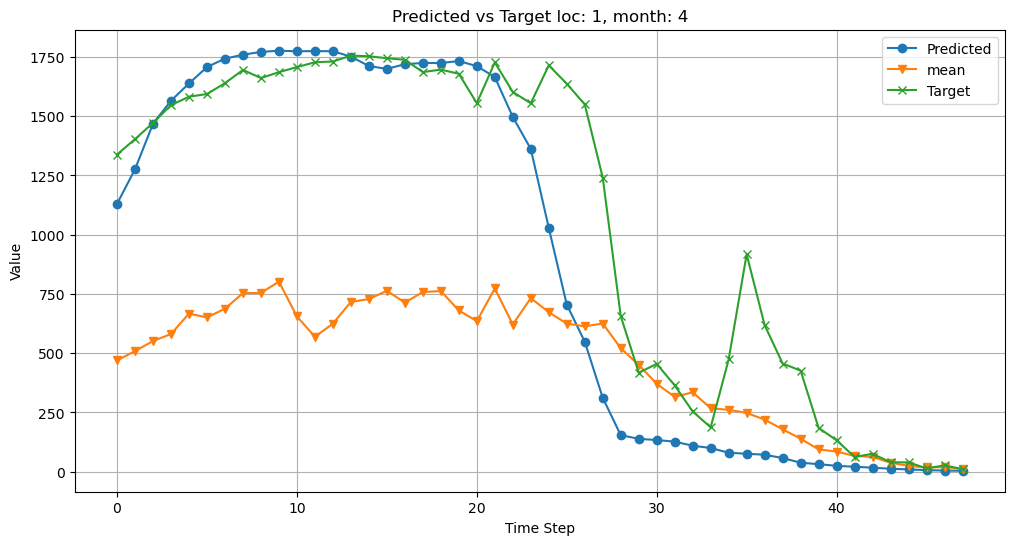

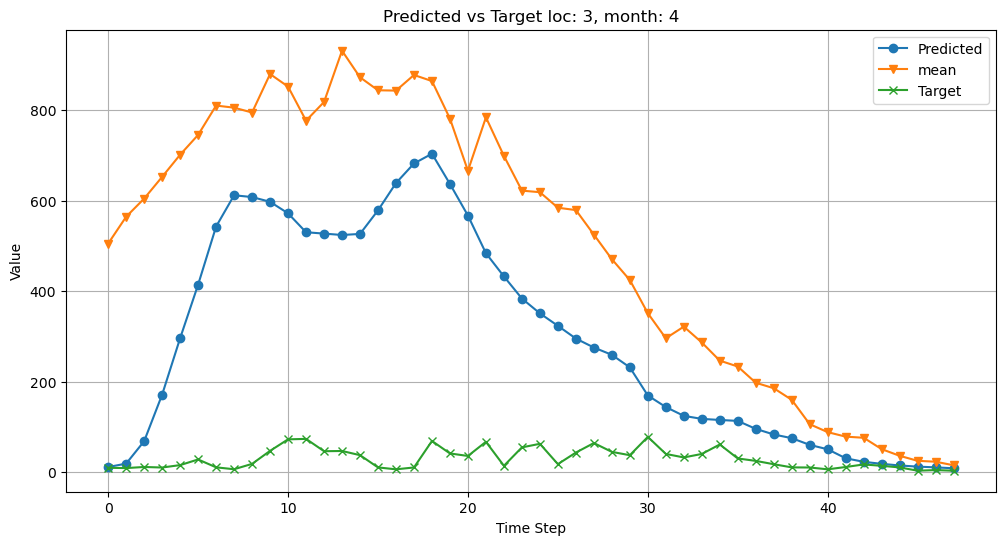

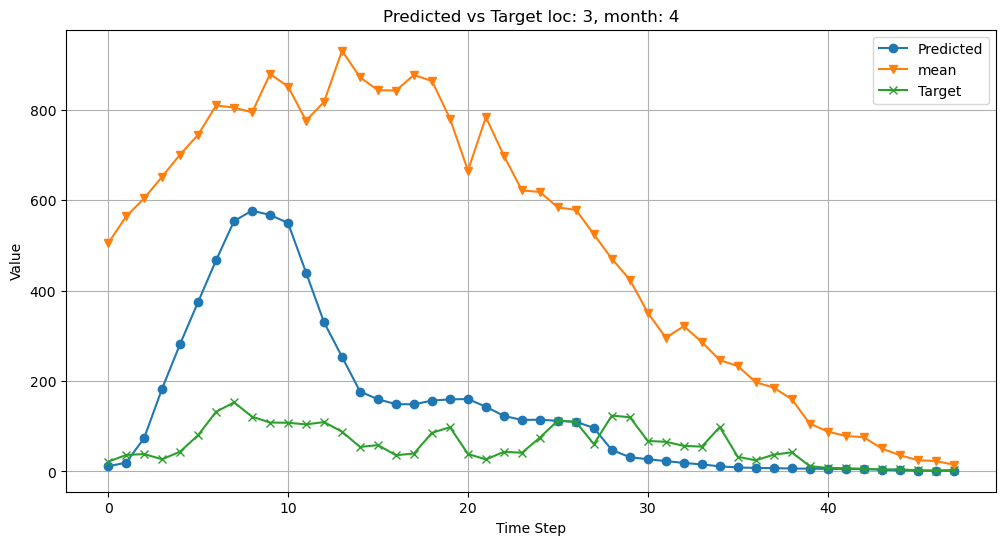

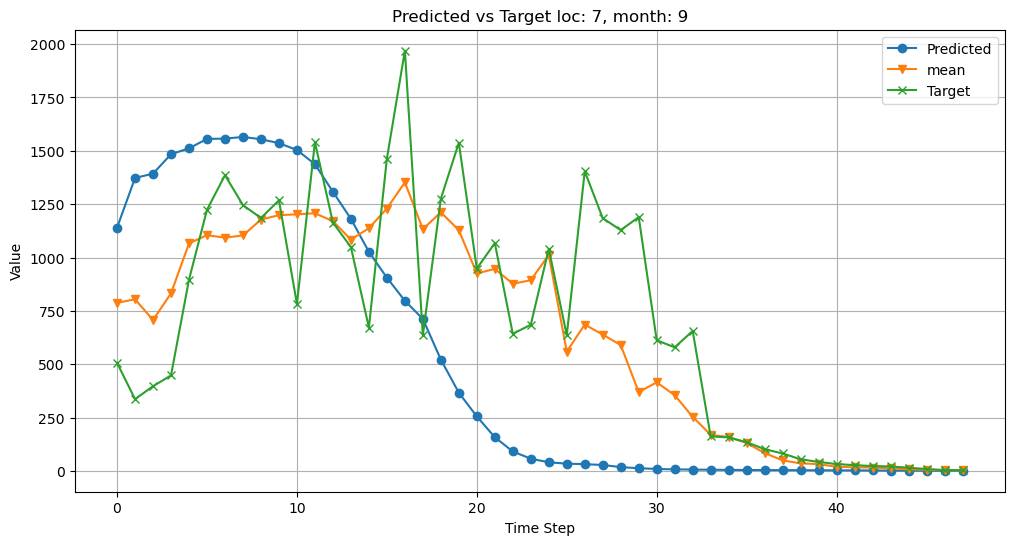

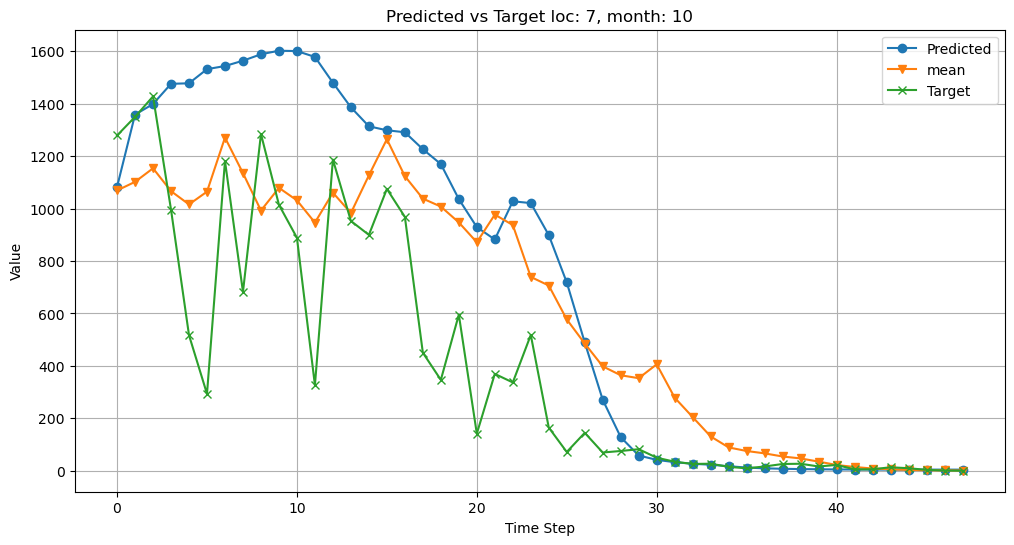

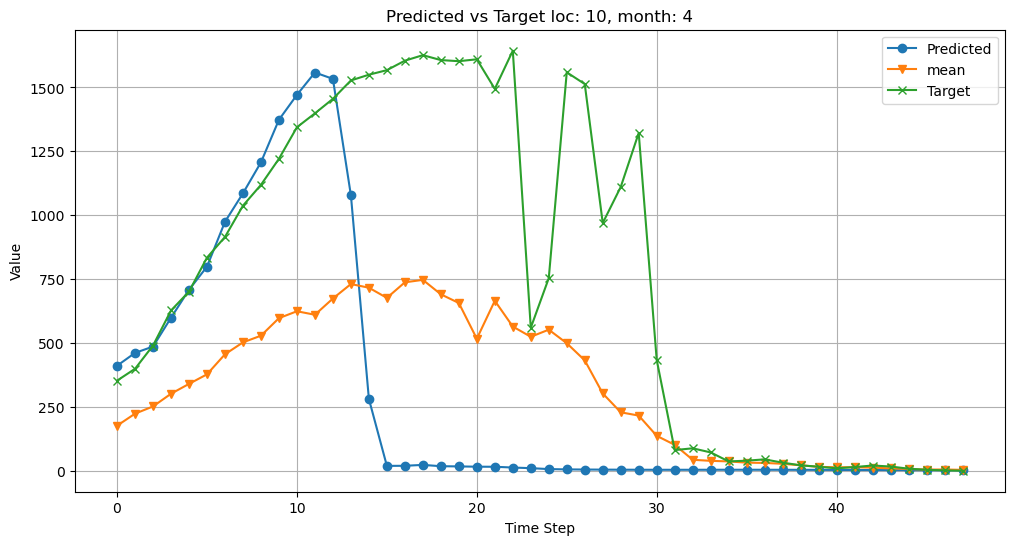

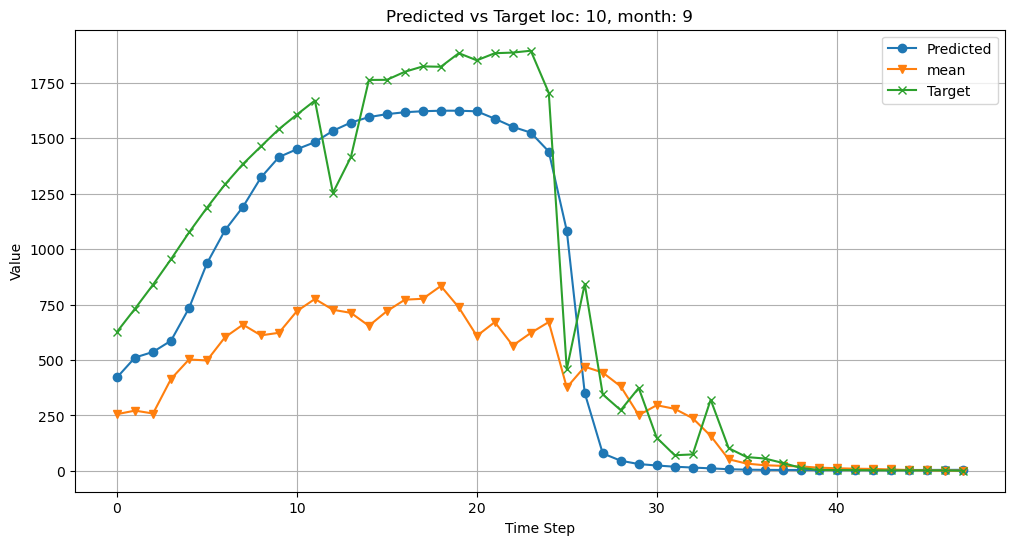

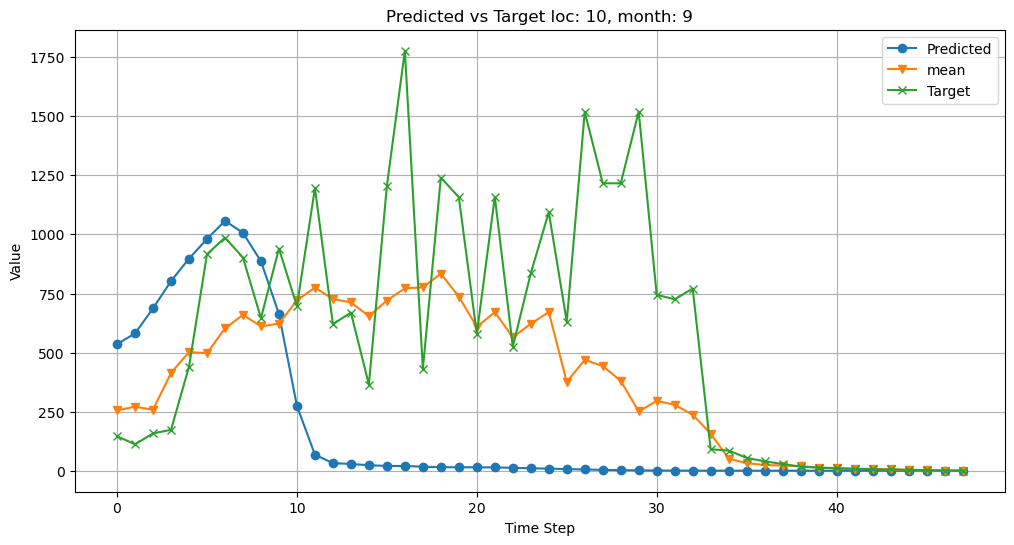

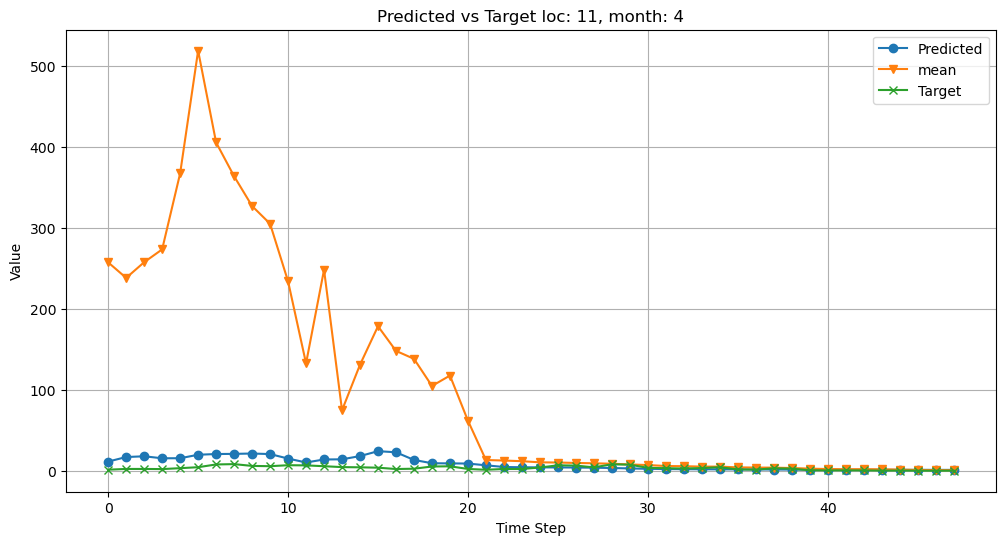

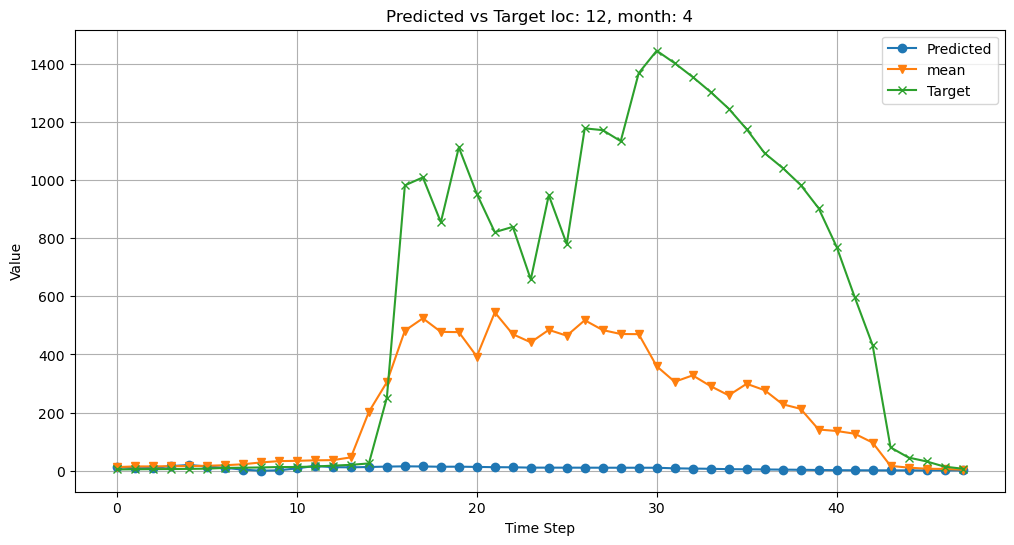

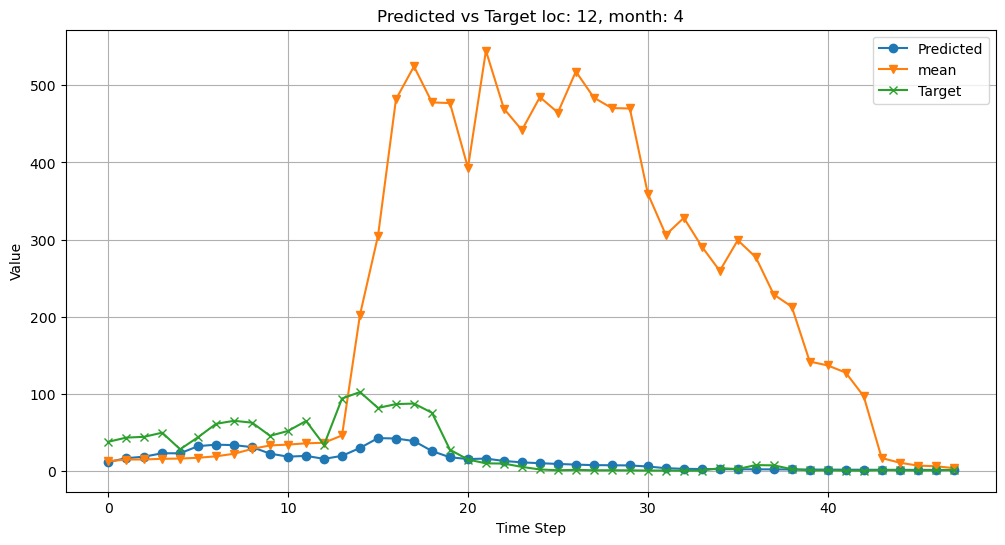

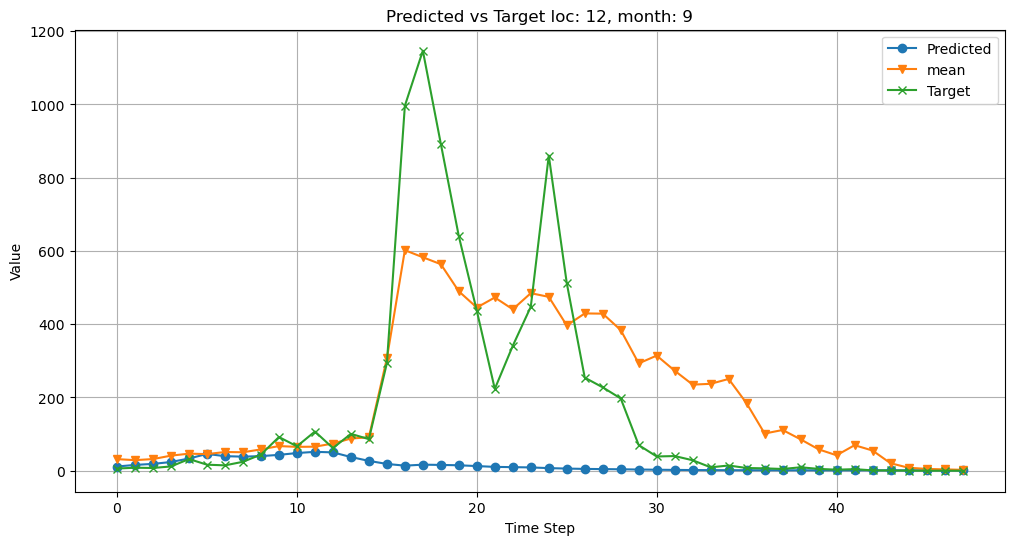

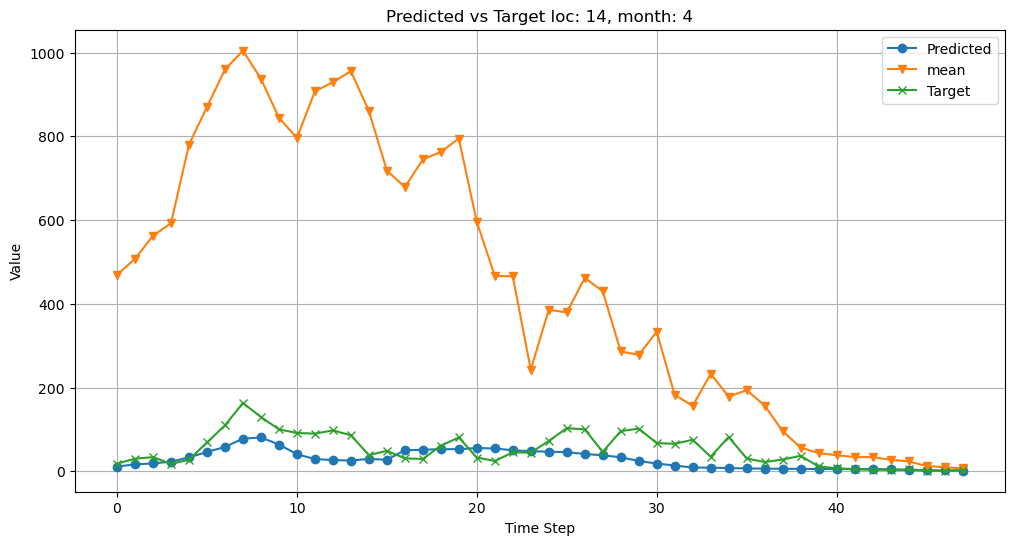

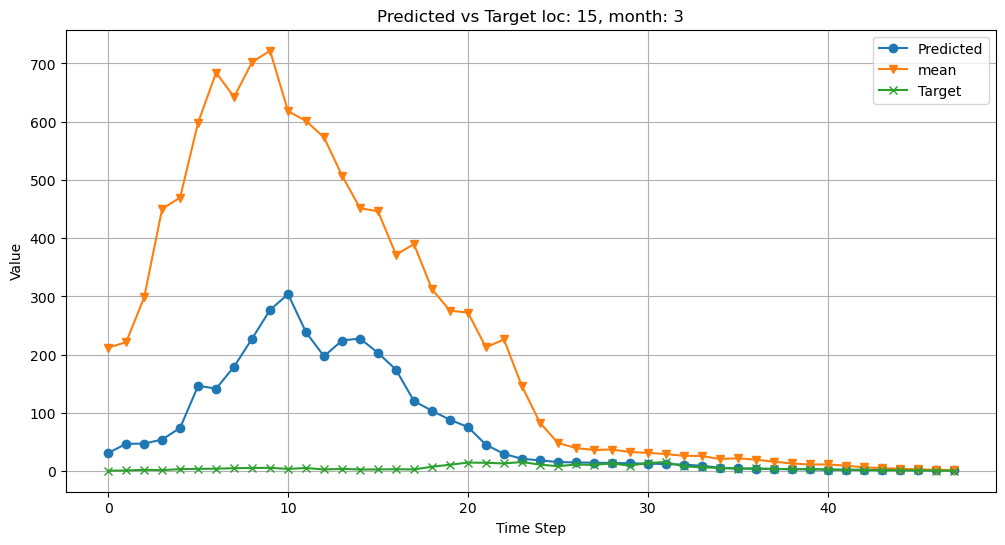

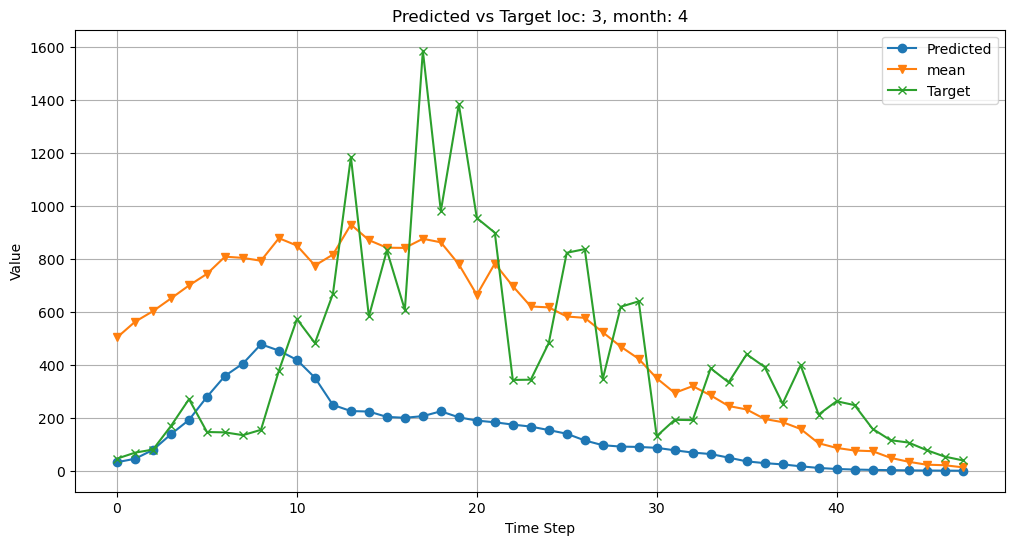

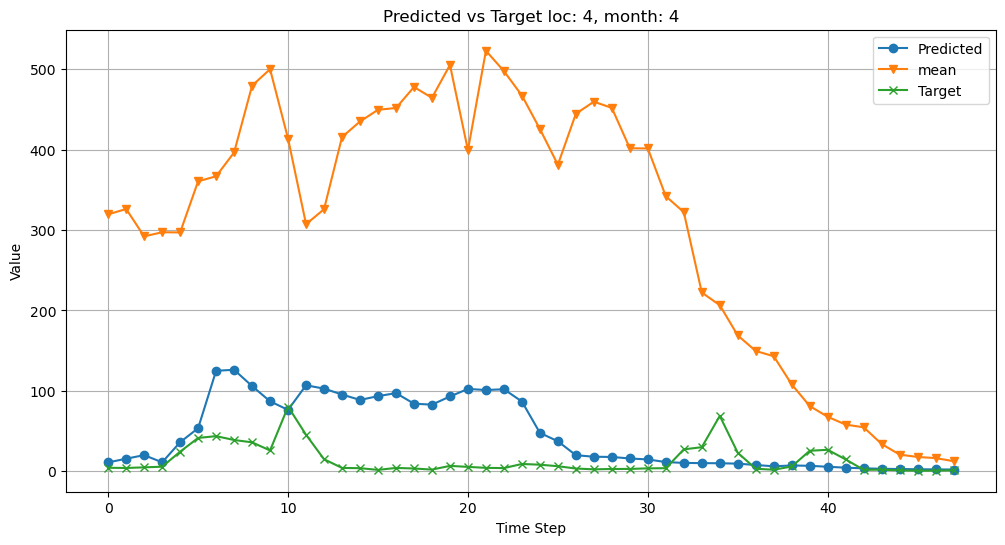

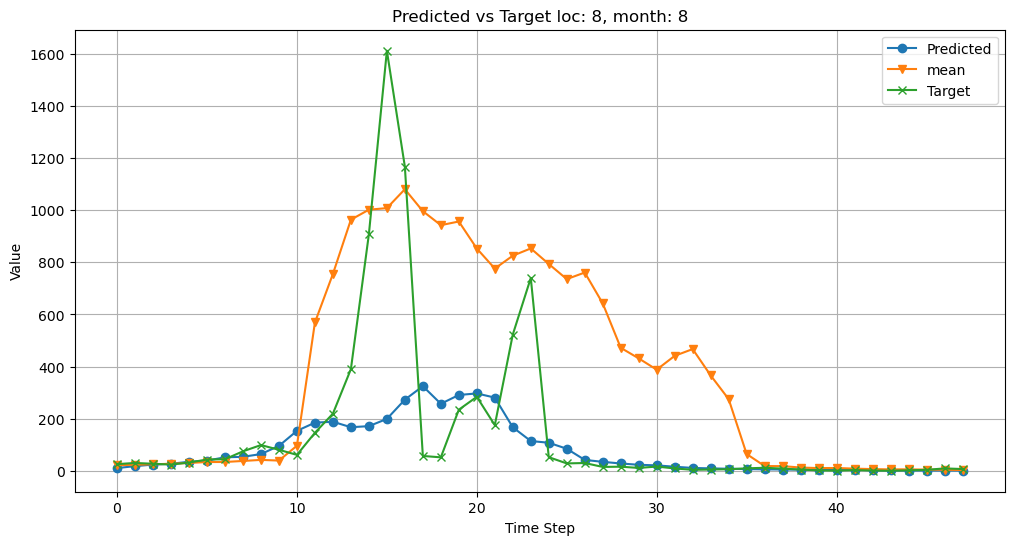

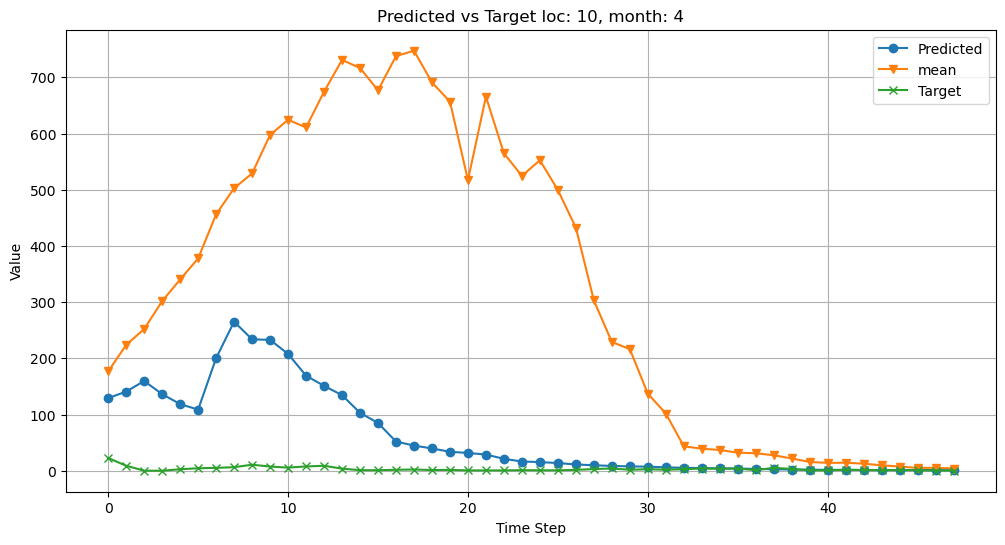

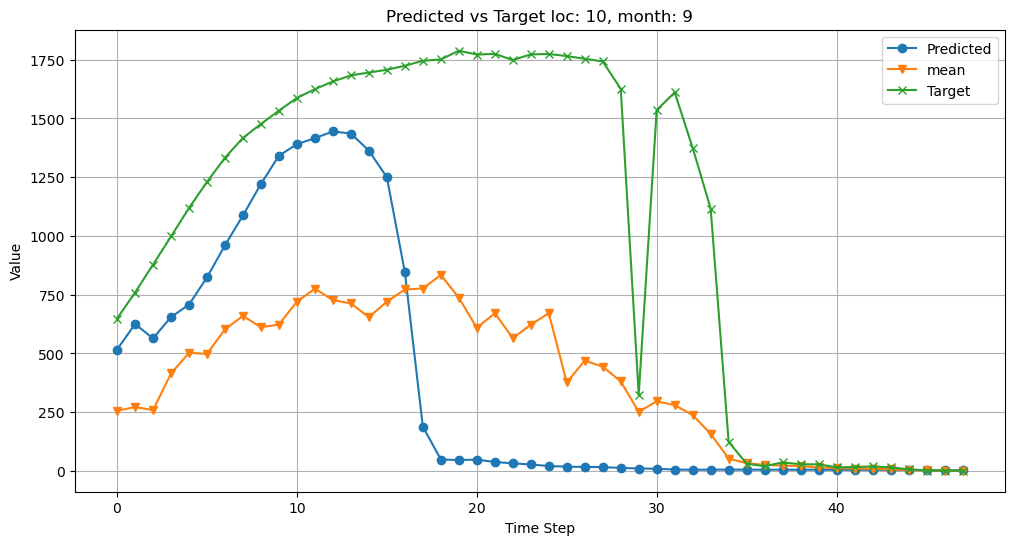

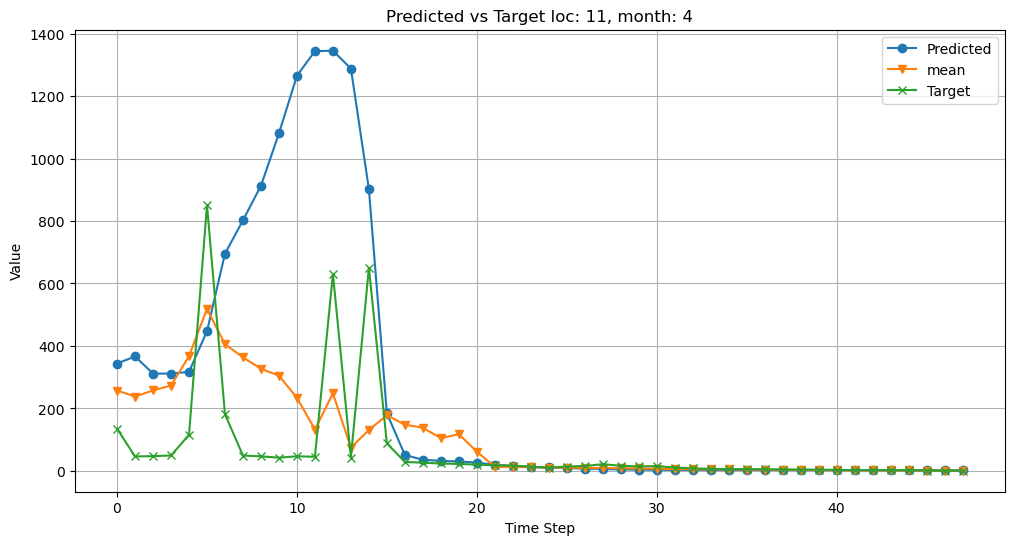

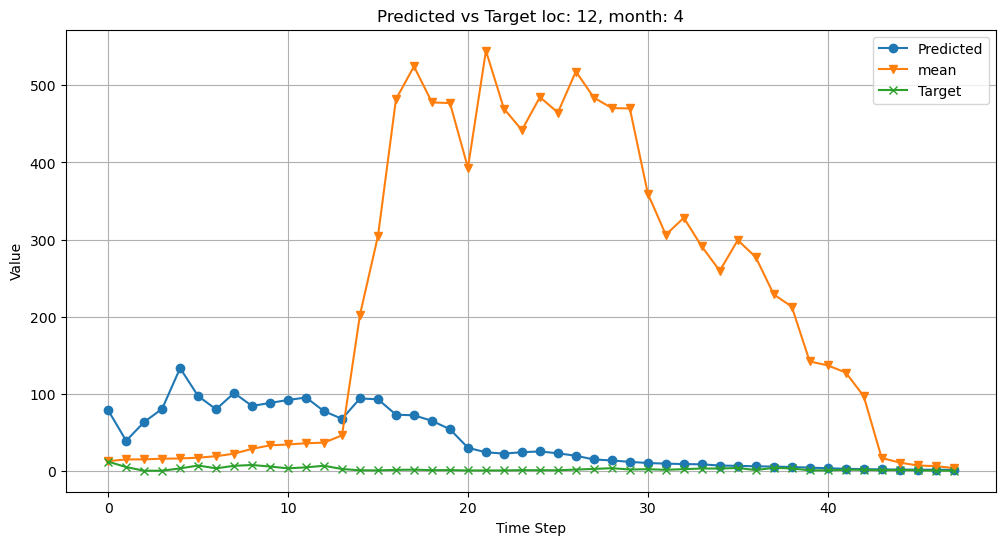

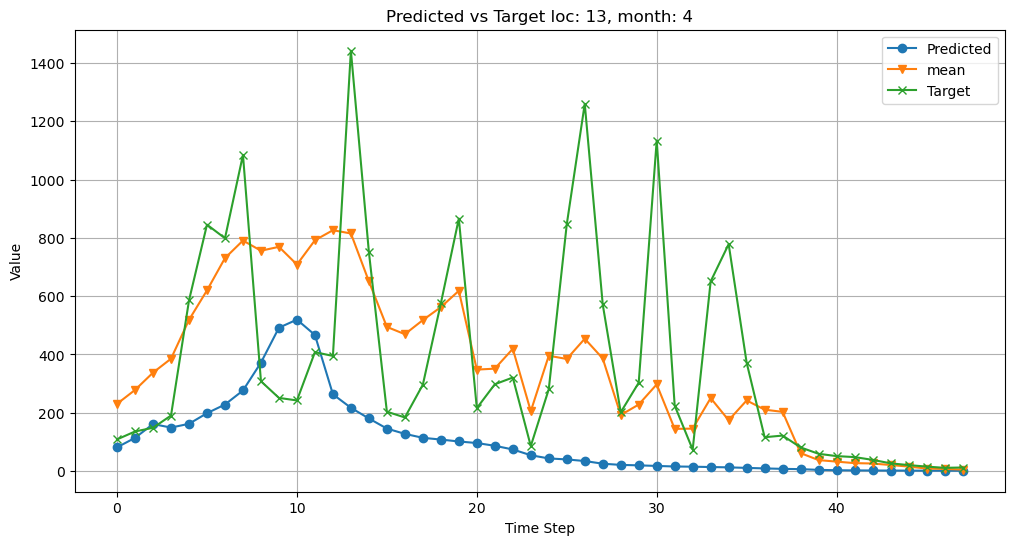

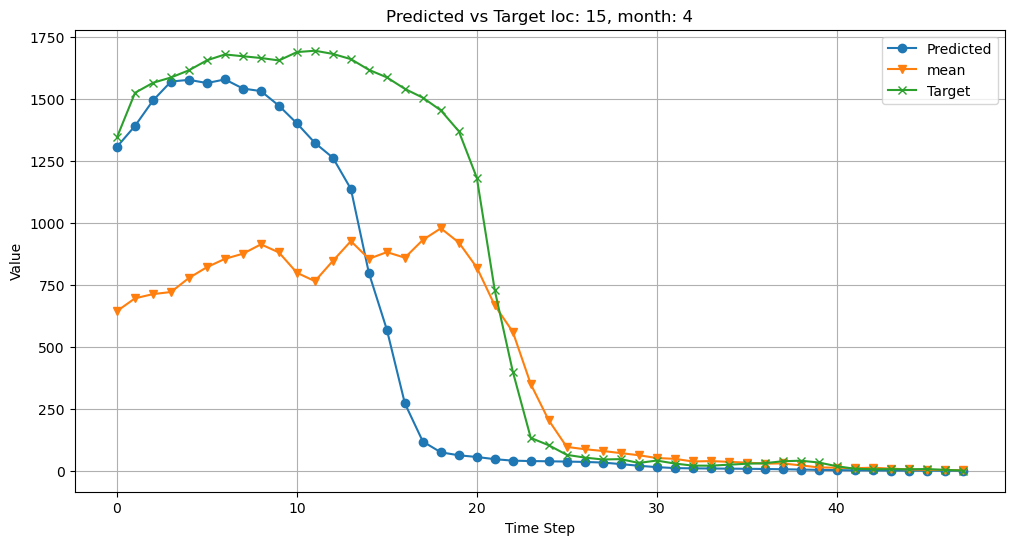

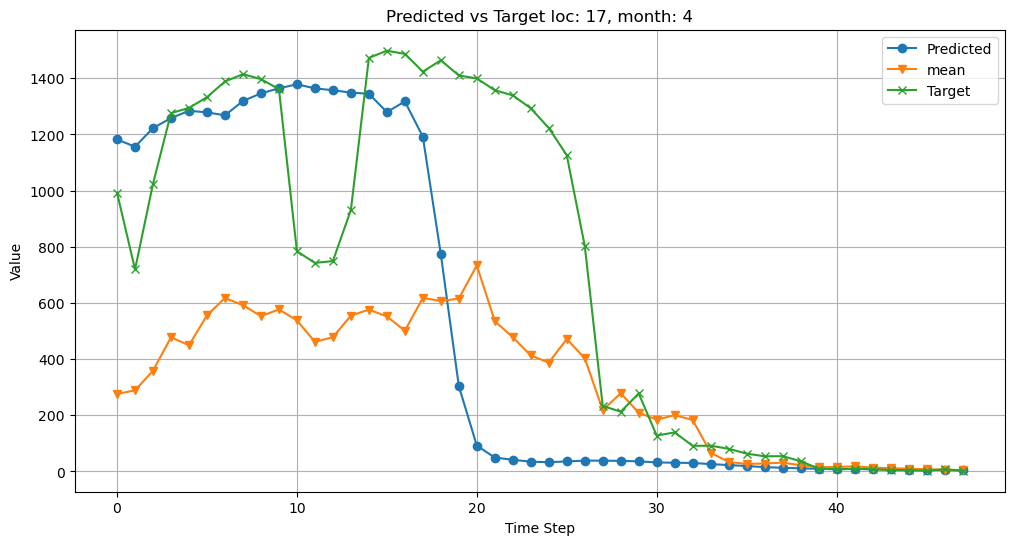

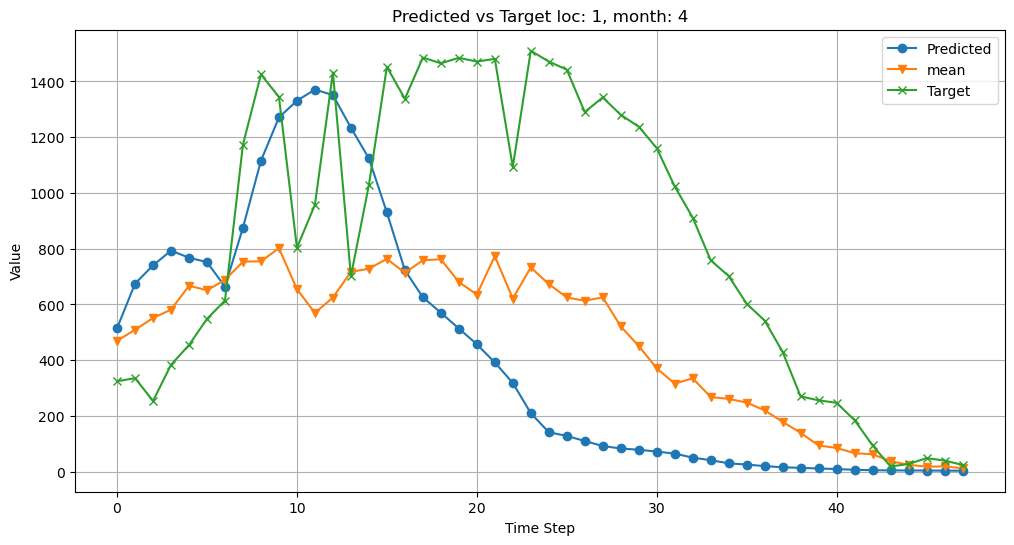

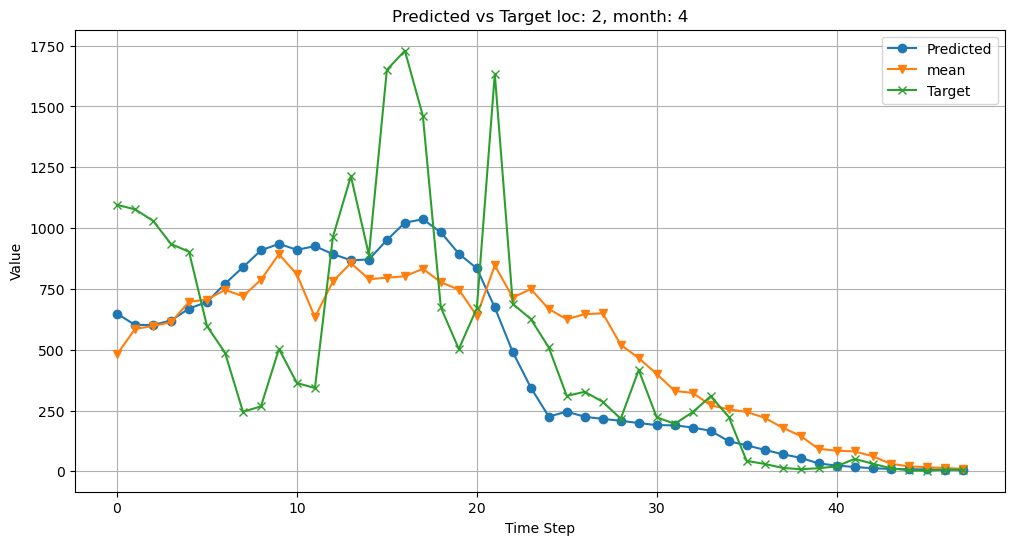

In [14]:
datas, support_datas, labels = valid_loader[0]

hidden = model.init_hidden(batch)
hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

datas, support_datas, labels = datas.to('cuda', dtype=torch.float32), support_datas.to('cuda', dtype=torch.float32), labels.to('cuda', dtype=torch.float32)

predicted, _ = model(datas, support_datas, hidden)
predicted = predicted.detach().to('cpu').numpy().squeeze()
target = labels.to('cpu').numpy()


print(predicted.shape, target.shape)
print(support_datas.shape)

copy_target_df['hour_min'] = copy_target_df['DateTime'].dt.hour * 100 + copy_target_df['DateTime'].dt.minute

for predicted_plot, target_plot, support_data in zip(predicted, target, support_datas):
    location_code = int(support_data[0, 0] * 17)
    month  = int(support_data[0, 1] * 12)
    loc_df = copy_target_df[copy_target_df["LocationCode"] == location_code]
    loc_df = loc_df[loc_df["month"] == month]


    hour_group = loc_df.groupby('hour_min').mean().reset_index()

    

    hour_9_17 = hour_group[hour_group['hour'] < 17]
    hour_9_17 = hour_9_17[hour_9_17['hour'] >= 9]
    hour_9_17_plot = list(hour_9_17['Power(mW)'])
    # 繪製折線圖
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_plot, label='Predicted', marker='o')
    plt.plot(hour_9_17_plot, label='mean', marker='v')
    plt.plot(target_plot, label='Target', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'Predicted vs Target loc: {location_code}, month: {month}')
    plt.legend()
    plt.grid()
    plt.show()


In [15]:
#取得上傳用資料
upload, upload_target_list = get_upload_target_list()
upload_data_batch, upload_support_data_batch = get_upload_data_list(target_df, upload_target_list)

upload_loader = list(zip(upload_data_batch, upload_support_data_batch))

In [16]:
min_num, max_num = 1e9, 0

for data in upload_data_batch:
    min_num = min(len(data), min_num)
    max_num = max(len(data), max_num)
print(min_num, max_num)

15 24


In [17]:


model.eval()
ans = []
with torch.no_grad():
    for datas, support_datas in upload_loader:
        # 將輸入和標籤移到 GPU
        datas, support_datas = datas.to(device, dtype=torch.float32), support_datas.to(device, dtype=torch.float)
        datas = datas.view(1, -1, datas.shape[1])
        support_datas = support_datas.view(1, -1, support_datas.shape[1])
        # 初始化隱藏狀態
        hidden = model.init_hidden(batch_size=datas.size(0))
        hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

        # 前向傳播
        outputs, _ = model(datas, support_datas, hidden)

        outputs = outputs.to('cpu', dtype=torch.float32)
        ans.extend(outputs.view(-1).tolist())



        

In [18]:
upload['答案'] = np.array(ans)
upload.to_csv('try.csv', index=False)